In this study, we are going to do a data analysis to see about how the engagement with digital learning relates to factors like district demographics, broadband access, and state/national level policies and events as a better understanding of digital learning trends. 


Used dataset: [kaggle](https://www.kaggle.com/c/learnplatform-covid19-impact-on-digital-learning/data)


**If you like this EDA, then please upvote the notebook.**

## List of tasks :
* Analyze the state of digital learning in 2020
* Relation of engagement in digital learning with district demographics (black, hispanic ...), broadband access, and 
state/national level policies and events.
* What is the effect of the COVID-19 pandemic on online and distance learning, and how might this also evolve in the future?
* How does student engagement with different types of education technology change over the course of the pandemic?
* How does student engagement with online learning platforms relate to different geography? Demographic context (e.g., race/ethnicity, ESL, learning disability)? Learning context? Socioeconomic status?
* Do certain state interventions, practices or policies (e.g., stimulus, reopening, eviction moratorium) correlate with the increase or decrease online engagement?

# **Loading Libraries!**

In [1]:
#import necessary package>
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib import patches
import plotly.express as px
import seaborn as sns
import glob
import re
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported!")

Libraries imported!


# **Exploratory Data Analysis**

The analysis will be performed in the following order:
* Product Data
* District Data
* Engagement Data.

# **Datasets**

* There are a total of 233 School Districts available within the data, all around USA. A school district is a geographical unit for the local administration of elementary or secondary schools in various nations.
* There are a total of 372 distinct Educational Technology Products, such as tools like Meet, Zoom, Canva, educational apps like Duolingo, reading sites, or social pages like Instagram.
* The data was collected between 01.01.2020 (a few months before Covid-19) until 31.12.2020. This will give a full year overview of a before the pandemic and after usage.
* Engagement data was collected for all the districts with ~ 22.3M datapoints. 

In [2]:
#datasets
path="../input/learnplatform-covid19-impact-on-digital-learning"

### Product information data
> The product file ```products_info.csv``` includes information about the characteristics of the top 372 products with most users in 2020. The categories listed in this file are part of LearnPlatform's product taxonomy. 

**Some products may not have labels due to being duplicate, lack of accurate url or other reasons.**


| Name                       | Description                                                                                                         |
|----------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| LP ID                      | The unique identifier of the product                                                                                                                                                                                                                                                                                           |
| URL                        | Web Link to the specific product                                                                                                                                                                                                                                                                                               |
| Product Name               | Name of the specific product                                                                                                                                                                                                                                                                                                   |
| Provider/Company Name      | Name of the product provider                                                                                                                                                                                                                                                                                                   |
| Sector(s)                  | Sector of education where the product is used                                                                                                                                                                                                                                                                                  |
| Primary Essential Function | The basic function of the product. There are two layers of labels here. Products are first labeled as one of these three categories: LC = Learning & Curriculum, CM = Classroom Management, and SDO = School & District Operations. Each of these categories have multiple sub-categories with which the products were labeled |
|                            |                                                                                                                                                                                

In [3]:
#reading the products data into data frame df_prod
df_prod = pd.read_csv(path+'/products_info.csv')
df_prod.head()  # printing the first 5 entries of dataframe 

LP ID                           URL  Product Name  Provider/Company Name  \
0  13117    https://www.splashmath.com   SplashLearn          StudyPad Inc.   
1  66933          https://abcmouse.com  ABCmouse.com  Age of Learning, Inc    
2  50479         https://www.abcya.com        ABCya!         ABCya.com, LLC   
3  92993         http://www.aleks.com/         ALEKS    McGraw-Hill PreK-12   
4  73104  https://www.achieve3000.com/   Achieve3000            Achieve3000   

            Sector(s)                         Primary Essential Function  
0             PreK-12                    LC - Digital Learning Platforms  
1             PreK-12                    LC - Digital Learning Platforms  
2             PreK-12  LC - Sites, Resources & Reference - Games & Si...  
3  PreK-12; Higher Ed                    LC - Digital Learning Platforms  
4             PreK-12                    LC - Digital Learning Platforms

In [4]:
df_prod.shape

(372, 6)

In [5]:
# how many unique provider are there

print('total unique products ', df_prod['LP ID'].unique().size)
print('total unique provider in top 372 products are ',df_prod['Provider/Company Name'].unique().size)
print('total unique sector are ',df_prod['Sector(s)'].unique().size)
a=list(df_prod['Sector(s)'].unique())
for i in a:
    print(i)
# some of the products are used in multiple sectors for example entries like 'PreK-12; Higher Ed'
# only three sectors are concerned here, prek-12, higher Ed and corporate


total unique products  372
total unique provider in top 372 products are  291
total unique sector are  6
PreK-12
PreK-12; Higher Ed
PreK-12; Higher Ed; Corporate
nan
Corporate
Higher Ed; Corporate


### District information data

>The district file ```districts_info.csv``` includes information about the **characteristics of school districts**, including data from 
>- NCES (2018-19), https://nces.ed.gov/
>- FCC (Dec 2018), and https://www.fcc.gov/
>- Edunomics Lab. https://edunomicslab.org/

Steps taken to preserve Privacy  
* Identifiable information about the school districts has been removed. 
* An open source tool ARX (Prasser et al. 2020) was used to transform several data fields and reduce the risks of re-identification. 

**For data generalization purposes some data points are released with a range where the actual value falls under. Additionally, there are many missing data marked as 'NaN' indicating that the data was suppressed to maximize anonymization of the dataset.**

| Name                   | Description                                                                                                                                                                                                                                                                              |
|------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| district_id            | The unique identifier of the school district                                                                                                                                                                                                                                             |
| state                  | The state where the district resides in                                                                                                                                                                                                                                                  |
| locale                 | NCES locale classification that categorizes U.S. territory into four types of areas: City, Suburban, Town, and Rural. See Locale Boundaries User's Manual for more information.                                                                                                          |
| pct_black/hispanic     | Percentage of students in the districts identified as Black or Hispanic based on 2018-19 NCES data                                                                                                                                                                                       |
| pct_free/reduced       | Percentage of students in the districts eligible for free or reduced-price lunch based on 2018-19 NCES data                                                                                                                                                                              |
| countyconnectionsratio | ratio (residential fixed high-speed connections over 200 kbps in at least one direction/households) based on the county level data from FCC From 477 (December 2018 version). See FCC data for more information.                                                                         |
| pptotalraw             | Per-pupil total expenditure (sum of local and federal expenditure) from Edunomics Lab's National Education Resource Database on Schools (NERD$) project. The expenditure data are school-by-school, and we use the median value to represent the expenditure of a given school district. |
                                                         

In [6]:
#loading districts data into dataframe
df_dist = pd.read_csv(path+'/districts_info.csv')
df_dist.head() 

district_id     state  locale pct_black/hispanic pct_free/reduced  \
0         8815  Illinois  Suburb           [0, 0.2[         [0, 0.2[   
1         2685       NaN     NaN                NaN              NaN   
2         4921      Utah  Suburb           [0, 0.2[       [0.2, 0.4[   
3         3188       NaN     NaN                NaN              NaN   
4         2238       NaN     NaN                NaN              NaN   

  county_connections_ratio    pp_total_raw  
0                [0.18, 1[  [14000, 16000[  
1                      NaN             NaN  
2                [0.18, 1[    [6000, 8000[  
3                      NaN             NaN  
4                      NaN             NaN

In [7]:
df_dist.shape

(233, 7)

* The data include a total of 233 school districts from across the US.
* For the columns pct_black/hispanic, pct_free/reduced, county_connections ratio and pp_total_raw a range is provided

### Engagement data
> The engagement data are aggregated at school district level, and each file in the folder ```engagement_data``` represents data from **one school district***. 

* The 4-digit file name represents ```district_id``` which can be used to link to district information in ```district_info.csv```. 

* The ```lp_id``` can be used to link to product information in ```product_info.csv```.

| Name             | Description                                                                                                    |
|------------------|----------------------------------------------------------------------------------------------------------------|
| time             | date in "YYYY-MM-DD"                                                                                           |
| lp_id            | The unique identifier of the product                                                                           |
| pct_access       | Percentage of students in the district have at least one page-load event of a given product and on a given day |
| engagement_index | Total page-load events per one thousand students of a given product and on a given day                         |

In [8]:
#engagement data
files = glob.glob(path+'/engagement_data/*.csv')
engagement = []

for filename in files:
    df_engage = pd.read_csv(filename, index_col=None, header=0)
    district_id = filename.split('/')[4].split('.')[0]
    df_engage['district_id'] = district_id
    engagement.append(df_engage)
    
df_engagement = pd.concat(engagement)
df_engagement = df_engagement.reset_index(drop=True)

df_engagement.head()

time    lp_id  pct_access  engagement_index district_id
0  2020-01-01  92844.0        0.01              0.68        6345
1  2020-01-01  64838.0        0.01              0.68        6345
2  2020-01-01  94058.0        0.00               NaN        6345
3  2020-01-01  26488.0        0.03             26.21        6345
4  2020-01-01  32340.0        0.01              0.11        6345

In [9]:
df_engagement.shape

(22324190, 5)

# **Missing Data**

* Important part of analyzing a data, is to study the missing values.
* Below cell defines a couple of function that will be used for missing values study

In [10]:
def missing_values(df):
    ''' This function takes a data frame as input 
    prints the fraction of entries with missing values (NaN)
    prints the list of columns with corresponding number of missing values
    '''
    # Total number of entries (rows X columns) in the dataset
    total= df.size
    #Number of missing values per column
    missingCount = df.isnull().sum()
    #Total number of missing values
    missing_tot = missingCount.sum()
    # Calculate percentage of missing values
    print('Total number of missing values for each column of dataframe: \n \b \b \b',missingCount)
    print("The dataset contains", round(((missing_tot/total) * 100), 2), "%", "missing values")
    print('Total number of rows with at least one missing value column are ',df[df.isnull().any(axis=1)].shape[0])
    print('% of rows with missing data ',round(((df[df.isnull().any(axis=1)].shape[0]/df.shape[0])*100),2),'%\n\n')
    
    
def column_missingdata(df):
    ''' This function takes a data frame as input 
    prints the list of columns with corresponding % of missing values
    '''
    #check for missing values per column
    values=df.isnull().sum()#.sort_values(ascending=False)
    total= df.size
    #percentage of missing values per column
    percentage=(values/total) * 100
    print('% of missing values for each column of dataframe: \n \b \b \b',percentage,'\n\n\n')

def plot_missingdata(df:pd.DataFrame, title:str, xlabel:str, ylabel:str):
    ''' This function takes a data frame as input 
    plots the list of columns with corresponding total number of missing values
    '''
    # Let us see what columns have missing values
    # total number of missing values for each dataframe column
    missing = df.isnull().sum() 
    # keeping only the columns with missing values>0 
    missing = missing[missing > 0] 
    # sorting in order of missing values and making the change to original missing series
    missing.sort_values(inplace=True) 
    missing.plot.bar()
    plt.title(title, size=15,loc='left')
    plt.xticks(fontsize=11,rotation=45)
    plt.yticks(fontsize=11)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.show()
    
    
def fix_missing_mean(df,col):
    ''' This function takes a data frame and column name as input 
    replaces the missing values of a particular column with it's mean value
    '''
    #replace missing values with mean 
    df[col].fillna(df[col].mean(), inplace = True)    

def fix_missing_mode(df,col):
    ''' This function takes a data frame and column name as input 
    replaces the missing values of a particular column with it's mode value
    '''
    #replace missing values with mean 
    df[col].fillna(df[col].mode(), inplace = True)    

    
def fix_missing_ffill(df, col):
    ''' This function takes a data frame and column name as input 
    replaces the missing values of a particular column with the value from the previous row
    '''
    df[col] = df[col].fillna(method='ffill')  
    
def fix_missing_bfill(df, col):
    ''' This function takes a data frame as input 
    replaces the missing values of a particular column with the value from the next row
    '''
    df[col] = df[col].fillna(method='bfill')     

### **Handling missing values for each dataframe**
Whether we like it or not, real world data is messy. Data cleaning is a major part of every data science project and every dataset can possibly have missing values for multiple columns corresponding to a data entry. Before starting to analyse the data and draw conclusions, it is necessary to understand the presence of missing values in our dataset.

We notice values like **NaN** are present in several columns of our dataset. This represent the missing values. We have used **isnull().sum()** to summarize total number of missing values per column. 

Now we need to decide how do we wish to handle them $!$

* **Remove rows with missing values:** The most elementary strategy is to remove all rows that contain missing values or, in extreme cases, entire columns that contain missing values.
* **Imputing Missing Values in our Dataset:** Removing rows is a good option when missing values are small. But this is not always practical. We need to replace these NaNs with intelligent guesses.
There are many options to pick from when replacing a missing value:
> * Replacing NaNs with a single constant value .
> * Replacing NaNs with the value from the previous row or the next row (using ffill or bfill method).
> * Replacing NaNs using Mean/Median/Mode of the column.
> * Using the replace method.

The details of the missing data and how to deal with those values for each datasets are described below.

## Missing values in Products dataset

In [11]:
# python library to study missing data
import missingno as msno

In [12]:
# explicitly printing the rows of products dataset with at least one missing value column
df_prod[df_prod.isnull().any(axis=1)].head()

LP ID                                                URL  \
61   33562                                http://www.ixl.com/   
146  83394                              https://www.yelp.com/   
158  63178                      http://www.learnplatform.com/   
174  32340                 http://genius.com/static/education   
183  85991  http://www.microsoft.com/en-us/education/produ...   

             Product Name Provider/Company Name Sector(s)  \
61           IXL Language          IXL Learning       NaN   
146                  Yelp             Yelp, Inc       NaN   
158         LearnPlatform               Lea(R)n       NaN   
174      Education Genius    Genius Media Group       NaN   
183  Microsoft Office 365             Microsoft       NaN   

    Primary Essential Function  
61                         NaN  
146                        NaN  
158                        NaN  
174                        NaN  
183                        NaN

### It will be better to make some summary tables and visualization to study the missing values

Total number of missing values for each column of dataframe: 
    LP ID                          0
URL                            0
Product Name                   0
Provider/Company Name          1
Sector(s)                     20
Primary Essential Function    20
dtype: int64
The dataset contains 1.84 % missing values
Total number of rows with at least one missing value column are  20
% of rows with missing data  5.38 %


% of missing values for each column of dataframe: 
    LP ID                         0.000000
URL                           0.000000
Product Name                  0.000000
Provider/Company Name         0.044803
Sector(s)                     0.896057
Primary Essential Function    0.896057
dtype: float64 





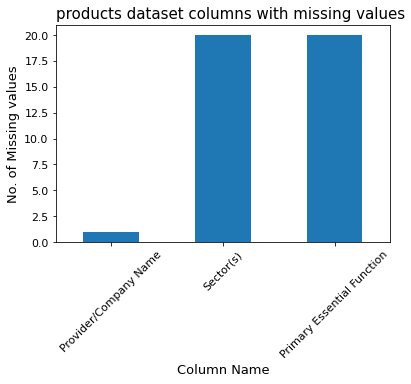

In [13]:
#products
missing_values(df_prod)
column_missingdata(df_prod)
plot_missingdata(df_prod,'products dataset columns with missing values','Column Name','No. of Missing values')

* 'Sector' and 'Primary Essential Function' column have almost all missing values.
* Lets check if the occurrence of missing values among these two columns is correlated.
* For this we are using python library **missingno**

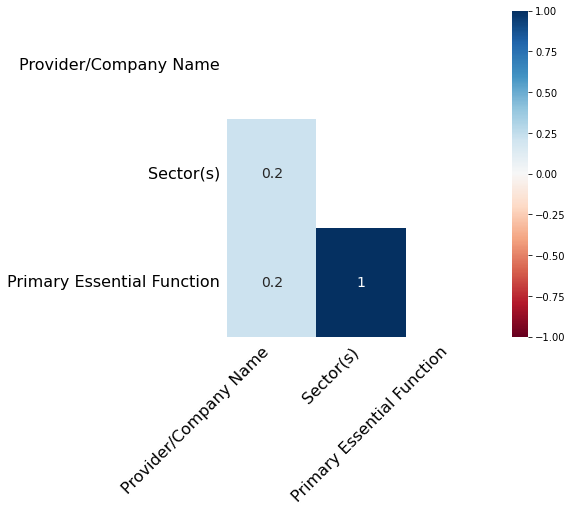

In [14]:
#heat map of missing value , it will show the corrrelation between different columns for missing values
ax = msno.heatmap(df_prod,figsize=(6,6))
plt.show()

* **As we saw from the output of cell 45, and above heat map if there is a missing value in 'Primary Essential Function column' then there is also a missing value in the Sector column**

**Summary for missing values in products data:**
* There are 3 columns with missing values which are **"Provider/Company Name"**, **"Sector(s)"** and **"Primary Essential Function"**.
* In this dataset we have very small fraction of missing values (1.84%) 
* The missing values in **"Sector(s)"** and **"Primary Essential Function"**. columns are 100% correlated.
* <span style="color:red"> We can drop all the rows with Nan values.</span>

In [15]:
# dropping all the rows with any missing values 
df_prod_x=df_prod
df_prod_x.dropna(axis=0,how='any',inplace=True)

#check missing columns in product dataset
column_missingdata(df_prod_x)

% of missing values for each column of dataframe: 
    LP ID                         0.0
URL                           0.0
Product Name                  0.0
Provider/Company Name         0.0
Sector(s)                     0.0
Primary Essential Function    0.0
dtype: float64 





In [16]:
df_prod_x.shape

(352, 6)

#### We have dropped all the **Nan** values and our dataset is cleaned now. There are 352 distinct educational technology products.

## Missing Values in District Dataset

Total number of missing values for each column of dataframe: 
    district_id                   0
state                        57
locale                       57
pct_black/hispanic           57
pct_free/reduced             85
county_connections_ratio     71
pp_total_raw                115
dtype: int64
The dataset contains 27.1 % missing values
Total number of rows with at least one missing value column are  145
% of rows with missing data  62.23 %


% of missing values for each column of dataframe: 
    district_id                 0.000000
state                       3.494788
locale                      3.494788
pct_black/hispanic          3.494788
pct_free/reduced            5.211527
county_connections_ratio    4.353158
pp_total_raw                7.050889
dtype: float64 





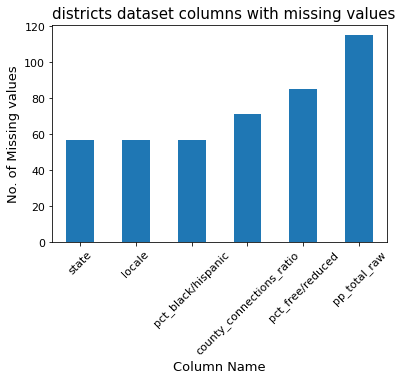

In [17]:
#district
missing_values(df_dist)
column_missingdata(df_dist)
plot_missingdata(df_dist,'districts dataset columns with missing values','Column Name','No. of Missing values')

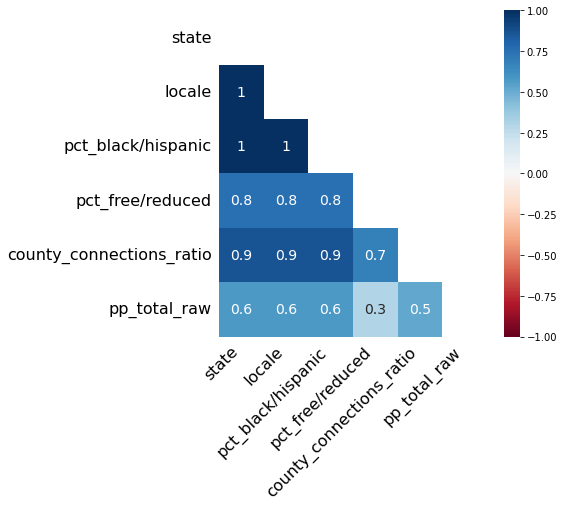

In [18]:
#heat map of missing value , it will show the corrrelation between different columns for missing values
ax = msno.heatmap(df_dist,figsize=(6,6))
plt.show()

**Missing values in districts data:**
* There are 6 columns with missing values which are **"state"**, **"locale"**, **"pct_black/hispanic"**, **"county_connections_ratio"**, **"pct_free/reduced"** and **"pp_total_raw"** in order of increasing number of missing values
* In this dataset we have a large fraction of missing values (27.1%) and dropping all the rows (39%) is not a good approach.
* Steps:
> * First, we can try to drop the rows for which a specific column (onw with minimum number of total missing values) has missing values. In this dataset we have **"state"**, **"locale"** and **"pct_black/hispanic"** with same fraction of missing values (3.49%) and are fully correlated. We can drop any of these column. Let's say we dropped **"locale"**. Now see how many columns are left with missing values! 

In [19]:
#district
#drop nan values in state column
df_dist_x = df_dist[df_dist["locale"].notna()].reset_index(drop=True)
#check missing columns in district dataset
column_missingdata(df_dist_x)


% of missing values for each column of dataframe: 
    district_id                 0.000000
state                       0.000000
locale                      0.000000
pct_black/hispanic          0.000000
pct_free/reduced            2.272727
county_connections_ratio    1.136364
pp_total_raw                4.707792
dtype: float64 





In [20]:
missing_values(df_dist_x)

Total number of missing values for each column of dataframe: 
    district_id                  0
state                        0
locale                       0
pct_black/hispanic           0
pct_free/reduced            28
county_connections_ratio    14
pp_total_raw                58
dtype: int64
The dataset contains 8.12 % missing values
Total number of rows with at least one missing value column are  88
% of rows with missing data  50.0 %




> * After dropping minimum number of missing values, we are left with 3 more columns which are 
  > > * pct_free/reduced=2.27$\%$
  > > * county_connections_ratio=1.14$\%$
  > > * pp_total_raw= 4.71$\%$
  
> * Now let's replace the **NaN** values of the column with **ffill** method.

In [21]:
fix_missing_ffill(df_dist_x,'pct_free/reduced')
fix_missing_ffill(df_dist_x,'county_connections_ratio')
fix_missing_ffill(df_dist_x,'pp_total_raw') 

In [22]:
df_dist_x.head()

district_id           state  locale pct_black/hispanic pct_free/reduced  \
0         8815        Illinois  Suburb           [0, 0.2[         [0, 0.2[   
1         4921            Utah  Suburb           [0, 0.2[       [0.2, 0.4[   
2         5987       Wisconsin  Suburb           [0, 0.2[         [0, 0.2[   
3         3710            Utah  Suburb           [0, 0.2[       [0.4, 0.6[   
4         7177  North Carolina  Suburb         [0.2, 0.4[       [0.2, 0.4[   

  county_connections_ratio    pp_total_raw  
0                [0.18, 1[  [14000, 16000[  
1                [0.18, 1[    [6000, 8000[  
2                [0.18, 1[  [10000, 12000[  
3                [0.18, 1[    [6000, 8000[  
4                [0.18, 1[   [8000, 10000[

In [23]:
df_dist_x.shape

(176, 7)

We have dropped all the **Nan** values and our dataset is cleaned now. The data include a total of 176 school districts from across the US.


**Engagement Data**

Total number of missing values for each column of dataframe: 
    time                      0
lp_id                   541
pct_access            13447
engagement_index    5378409
district_id               0
dtype: int64
The dataset contains 4.83 % missing values
Total number of rows with at least one missing value column are  5378889
% of rows with missing data  24.09 %


% of missing values for each column of dataframe: 
    time                0.000000
lp_id               0.000485
pct_access          0.012047
engagement_index    4.818458
district_id         0.000000
dtype: float64 





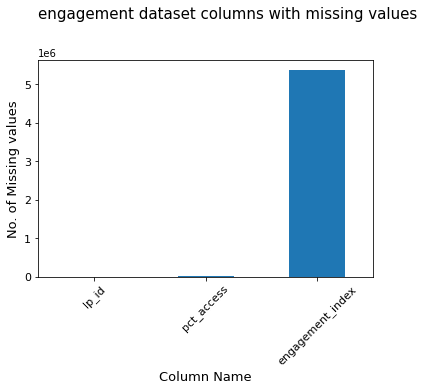

In [24]:
#engagement
missing_values(df_engagement)
column_missingdata(df_engagement)
plot_missingdata(df_engagement,'engagement dataset columns with missing values\n\n','Column Name','No. of Missing values')

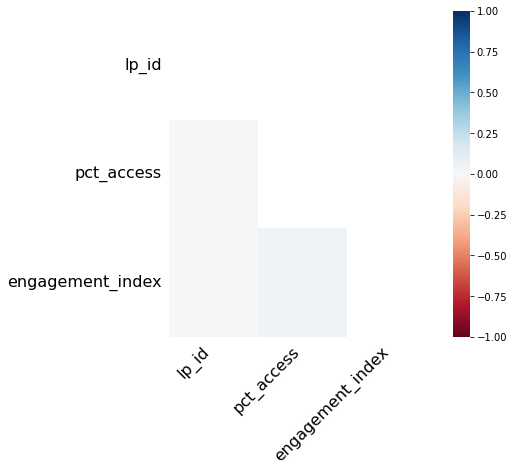

In [25]:
#heat map of missing value , it will show the corrrelation between different columns for missing values
ax = msno.heatmap(df_engagement,figsize=(6,6))
plt.show()

**Missing values in engagement data:**
* There are 3 columns with missing values which are **"lp_id"**, **"pct_access"** and **"engagement_index"**.
* In this dataset we have around 4.83% fraction of missing values and we will follow the similar approach as we did in district data.
* Steps:
> * Firstly, we drop the column with minimum number of missing values which is **"lp_id"**. 
> * Secoundly, we will replace the **NaN** values in the remaining columns with it's mean value.


In [26]:
#drop nan values in lp_id column
df_engagement_x = df_engagement[df_engagement["lp_id"].notna()].reset_index(drop=True)

# fill the missing values with mean value of the column in the engagement dataset
fix_missing_mean(df_engagement_x,'pct_access')
fix_missing_mean(df_engagement_x,'engagement_index')

In [27]:
df_engagement.head()

time    lp_id  pct_access  engagement_index district_id
0  2020-01-01  92844.0        0.01              0.68        6345
1  2020-01-01  64838.0        0.01              0.68        6345
2  2020-01-01  94058.0        0.00               NaN        6345
3  2020-01-01  26488.0        0.03             26.21        6345
4  2020-01-01  32340.0        0.01              0.11        6345

In [28]:
#check missing columns in enagement dataset
column_missingdata(df_engagement_x)

% of missing values for each column of dataframe: 
    time                0.0
lp_id               0.0
pct_access          0.0
engagement_index    0.0
district_id         0.0
dtype: float64 





We have dropped all the **Nan** values and our dataset is cleaned now. 

# **Analysis**

In [29]:
#defining functions for plots
#countplot
def plot_count(df:pd.DataFrame, y_col:str, title:str, xlabel:str, ylabel:str):
    fig, ax = plt.subplots(1, 1, figsize=(10,6), sharey=True)
    sns.countplot(data=df, y=y_col,edgecolor="white",palette="viridis",order=df[y_col].value_counts().index)
    total = df[y_col].value_counts().sum()
    for i, v in enumerate(df[y_col].value_counts().sort_values(ascending=False).values): 
        frac1 = (v/total)*100
        frac = "{:.2f}".format(frac1)
        v1 = str(v)+' ('+str(frac)+'%)'
        ax.text(v*1.01, i, v1,fontsize=10,color='black',weight='bold')
   
    plt.title(title, size=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.show()
    
#pieplot_for locale
def plot_pie(df:pd.DataFrame,column:str, title:str):
    fig, ax  = plt.subplots(figsize=(16, 8))
    fig.suptitle(column+' Distribution', font="Serif",fontsize=20)
    explode = (0.01, 0.01, 0.01, 0.01) 
    labels = list(df[column].value_counts().index)
    sizes = df[column].value_counts().values
    ax.pie(sizes, 
           explode=explode,
           startangle=60, 
           labels=labels,
           autopct='%1.0f%%', 
           pctdistance=0.7)
    ax.add_artist(plt.Circle((0,0),0.5,fc='white'))
plt.show()
    
#barplot   
def plot_bar(df:pd.DataFrame,minimum:str,maximum:str,y_col:str, title:str, xlabel:str, ylabel:str):
    df1 = df.groupby(y_col)[minimum, maximum].mean().sort_values([minimum, maximum],ascending=False)
    df1.plot(kind = 'bar',color=['blue','darkblue'])
    plt.title(title, size=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.show()


def plot_barh(df:pd.DataFrame, x_col:pd.DataFrame,y_col:pd.DataFrame, title:str, xlabel:str,ylabel:str):
    fig, ax  = plt.subplots(figsize=(10,6))    
    sns.barplot(data = df,y=y_col,x=x_col,palette="viridis")
    plt.title(title, size=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.show()
    
def plot_bar1(df:pd.DataFrame, x_col:pd.DataFrame,y_col:pd.DataFrame, title:str, xlabel:str,ylabel:str):
    fig, ax  = plt.subplots(figsize=(10,6)) 
    sns.barplot(data = df,y=y_col,x=x_col,palette="viridis",order=df.groupby(y_col).mean()[x_col].sort_values(ascending=False).index,ci=None)
    plt.title(title, size=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.show()
    
    
def plot_bar2(df1:pd.DataFrame, x_col:str,y_col1:str, ax1_title:str, xlabel1:str,ylabel1:str,df2:pd.DataFrame,y_col2:str,ax2_title:str, xlabel2:str,ylabel2:str):
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    sns.barplot(data = df1,y=y_col1,x=x_col,palette="viridis", ax=ax[0])
    ax[0].set_title(ax1_title)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
    ax[0].set_xlabel(xlabel1)
    ax[0].set_ylabel(ylabel1)

    sns.barplot(data = df2,y=y_col2,x=x_col,palette="viridis", ax=ax[1])
    ax[1].set_title(ax2_title)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
    ax[1].set_xlabel(xlabel2)
    ax[1].set_ylabel(ylabel2)
    plt.show()    
    
def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str, title: str, hue: str):
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data = df, x=x_col, y=y_col, hue=hue, size=hue,sizes=(20, 200))
    plt.title(title, size=20)
    plt.xticks(fontsize=14)
    plt.yticks( fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.show() 
    
def plot_pairplot(df: pd.DataFrame):#, hue:str, diag_kind:str
    sns.pairplot(df)
    #pd.plotting.scatter_matrix(df, alpha=0.2)
    plt.show() 
    
    
def plot_line(df: pd.DataFrame,x_col: str, y_col: str, hue: str, title:str, xlabel:str, ylabel:str, text1:int, text2:int):#, hue:str, diag_kind:str
    fig, ax  = plt.subplots(figsize=(15,7))    
    sns.lineplot(data=df, x=x_col, y=y_col, hue=hue,lw=2)
    plt.title(title, size=30)
    plt.xticks(fontsize=20)#,rotation=45)
    plt.yticks(fontsize=20)
    plt.xlabel(xlabel, fontsize=30)
    plt.ylabel(ylabel, fontsize=30)
    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.axvline(pd.Timestamp('2020-03-11'),color='black')
    ax.text(pd.Timestamp("2020-03-11"), text1, "  WHO has declared Covid-19 a pandemic",size=20,fontname = 'monospace',color='black')
    xy = datetime(2020,6,1,0,0,0), ax.get_ylim()[0]
    w, h = timedelta(days=92), ax.get_ylim()[1] - ax.get_ylim()[0]
    ax.add_patch(patches.Rectangle(xy, w, h,color ='black',alpha=0.1))
    ax.text(pd.Timestamp("2020-06-17"), text2, "Summer Break",size=20,fontname = 'monospace',color='black')
    plt.show() 
    
def plot_line_day(df: pd.DataFrame,x_col: str, y_col: str, hue: str, title:str, xlabel:str, ylabel:str, text1:int, text2:int):#, hue:str, diag_kind:str
    fig, ax  = plt.subplots(figsize=(15,7))    
    sns.lineplot(data=df, x=x_col, y=y_col, hue=hue,style=hue,ci=None,markers=False, dashes=False, lw=2)
    plt.title(title, size=30)
    plt.xticks(fontsize=20)#,rotation=45)
    plt.yticks(fontsize=20)
    plt.xlabel(xlabel, fontsize=30)
    plt.ylabel(ylabel, fontsize=30)
    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.show()     

## **Districts Data:**

**Group by state**

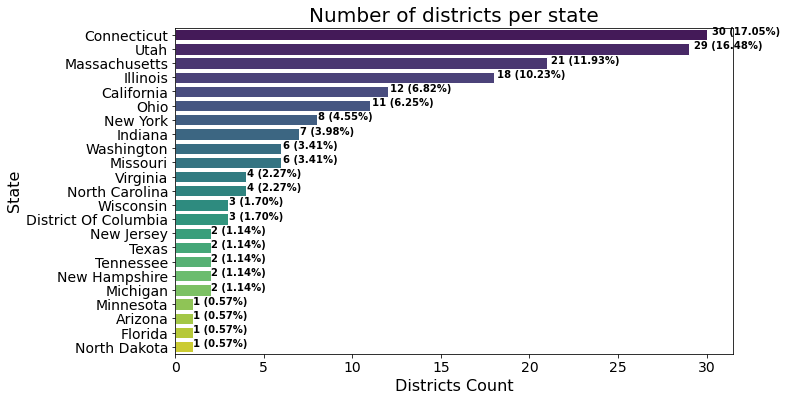

In [30]:
plot_count(df_dist_x,'state','Number of districts per state','Districts Count','State')

* This distribution shows the number of school districts for each state.
* In this dataset, <span style='color:red'> Connecticut </span> has the most number of school districts (17%) while <span style='color:blue'> Minnesota </span>
,<span style='color:blue'> Arizona </span>,<span style='color:blue'> Florida </span> and <span style='color:blue'> North Dakota</span> has the least number of school districts (1%).


**Group by locale**

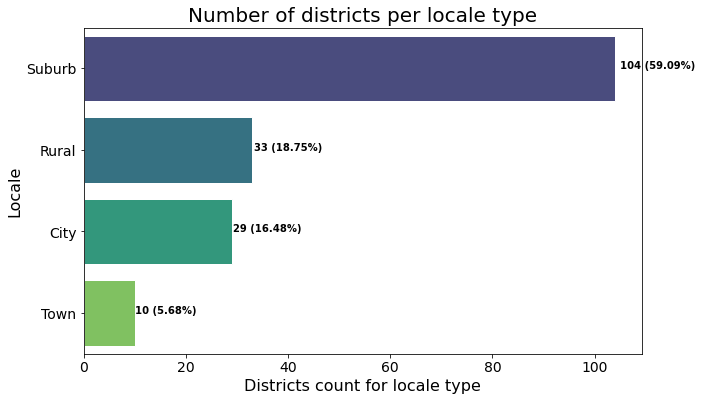

In [31]:
#barplot
plot_count(df_dist_x,'locale','Number of districts per locale type','Districts count for locale type','Locale')

* This distribution shows the number of districts in each locale. 
* Let's plot a pie chart for a better visualization.

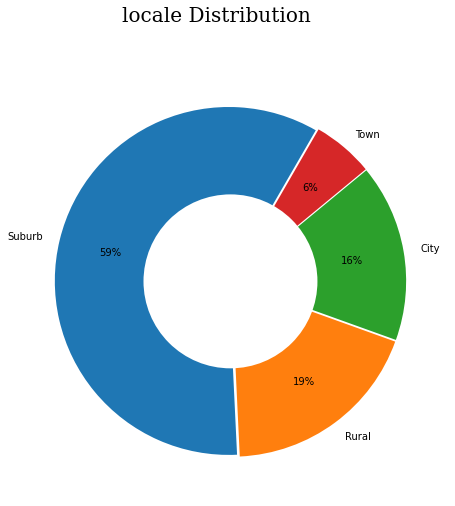

In [32]:
#pie plot
plot_pie(df_dist_x,'locale','Number of districts per locale')

* Total 59% of the districts are in the <span style='color:red'> suburbs </span> while the <span style='color:blue'> towns </span> have the least number of districts (5.68%).

 **Preprocessing some of the columns in the districts datasets**
 * for the columns 'pct_black/hispanic', 'pct_free/reduced', 'county_connections_ratio' and 'pp_total_raw' we have a range of values, we will split them into two separate columns each with min and max values in the range 

In [33]:
#we have spiltted columns like 'pct_black/hispanic', 'pct_free/reduced', 'county_connections_ratio' and 'pp_total_raw' into 2 different columns based on their maximum and minimum value
df_dist1=df_dist_x
#'pct_black/hispanic'
df_dist1[['min_pct_black/hispanic','max_pct_black/hispanic']] = df_dist1['pct_black/hispanic'].str.split(",",expand=True)
df_dist1['min_pct_black/hispanic'] = df_dist1['min_pct_black/hispanic'].str.strip('[')
df_dist1['max_pct_black/hispanic'] = df_dist1['max_pct_black/hispanic'].str.strip('[')

#'pct_free/reduced'
df_dist1[['min_pct_free/reduced','max_pct_free/reduced']] = df_dist1['pct_free/reduced'].str.split(",",expand=True)
df_dist1['min_pct_free/reduced'] = df_dist1['min_pct_free/reduced'].str.strip('[')
df_dist1['max_pct_free/reduced'] = df_dist1['max_pct_free/reduced'].str.strip('[')

#'county_connections_ratio'
df_dist1[['min_county_connections_ratio','max_county_connections_ratio']] = df_dist1['county_connections_ratio'].str.split(",",expand=True)
df_dist1['min_county_connections_ratio'] = df_dist1['min_county_connections_ratio'].str.strip('[')
df_dist1['max_county_connections_ratio'] = df_dist1['max_county_connections_ratio'].str.strip('[')

#'pp_total_raw'
df_dist1[['min_pp_total_raw','max_pp_total_raw']] = df_dist1['pp_total_raw'].str.split(",",expand=True)
df_dist1['min_pp_total_raw'] = df_dist1['min_pp_total_raw'].str.strip('[')
df_dist1['max_pp_total_raw'] = df_dist1['max_pp_total_raw'].str.strip('[')

#import the original columns
df_dist1.drop(['pct_black/hispanic', 'pct_free/reduced', 'county_connections_ratio', 'pp_total_raw'], axis = 1, inplace = True)

In [34]:
df_dist1.dtypes

district_id                      int64
state                           object
locale                          object
min_pct_black/hispanic          object
max_pct_black/hispanic          object
min_pct_free/reduced            object
max_pct_free/reduced            object
min_county_connections_ratio    object
max_county_connections_ratio    object
min_pp_total_raw                object
max_pp_total_raw                object
dtype: object

In [35]:
#convert object to numbers
cols = df_dist1.columns.drop(['state', 'locale'])
df_dist1[cols] = df_dist1[cols].apply(pd.to_numeric, errors = 'coerce')

In [36]:
#except state and locale we have converted all others object columns to numeric columns
df_dist.dtypes

district_id                  int64
state                       object
locale                      object
pct_black/hispanic          object
pct_free/reduced            object
county_connections_ratio    object
pp_total_raw                object
dtype: object

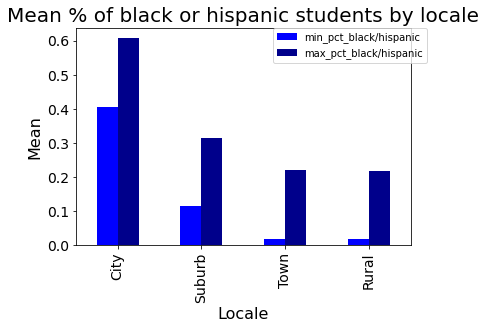

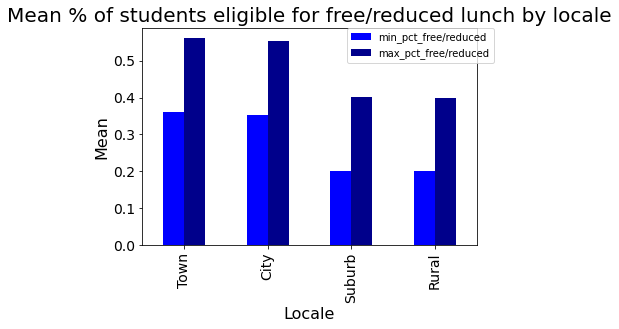

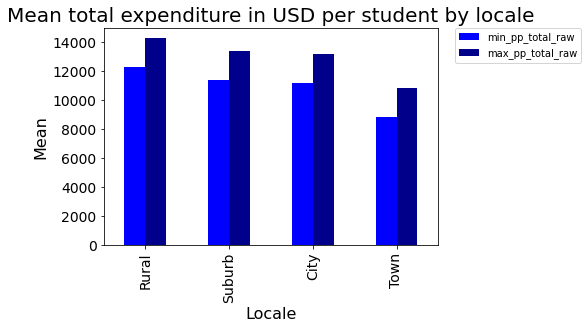

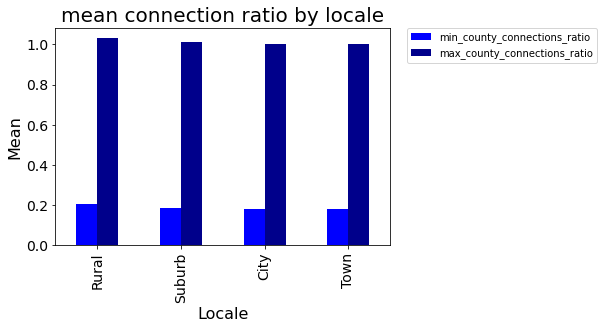

In [37]:
plot_bar(df_dist1,'min_pct_black/hispanic','max_pct_black/hispanic','locale','Mean % of black or hispanic students by locale','Locale','Mean')
plot_bar(df_dist1,'min_pct_free/reduced','max_pct_free/reduced','locale','Mean % of students eligible for free/reduced lunch by locale','Locale','Mean')
plot_bar(df_dist1,'min_pp_total_raw','max_pp_total_raw','locale','Mean total expenditure in USD per student by locale','Locale','Mean')
plot_bar(df_dist1,'min_county_connections_ratio','max_county_connections_ratio','locale','mean connection ratio by locale','Locale','Mean')

* The largest count of students who identified themselves as Black or Hispanic are in locale type cities. The smallest count is in the town and rural areas.
* The maximum and minimum percentage of students in the districts eligible for free or reduced-price lunch is the highest in the **town**, followed by city, suburb and rural.
* The highest total expenses per student is in rural area.
* The data for county connections ratio has similar range for all locales.

In [38]:
df_dist1["avg_pct_black/hispanic"] = df_dist1[["min_pct_black/hispanic", "max_pct_black/hispanic"]].mean(axis=1)
df_dist1["avg_pct_free/reduced"] = df_dist1[["min_pct_free/reduced", "max_pct_free/reduced"]].mean(axis=1)
df_dist1["avg_pp_total_raw"] = df_dist1[["min_pp_total_raw", "max_pp_total_raw"]].mean(axis=1)
df_dist1["avg_county_connections_ratio"] = df_dist1[["min_county_connections_ratio", "max_county_connections_ratio"]].mean(axis=1)

In [39]:
df_dist1[df_dist1['state']=='North Dakota']

district_id         state locale  min_pct_black/hispanic  \
91         2872  North Dakota  Rural                     0.0   

    max_pct_black/hispanic  min_pct_free/reduced  max_pct_free/reduced  \
91                     0.2                   0.0                   0.2   

    min_county_connections_ratio  max_county_connections_ratio  \
91                           1.0                             2   

    min_pp_total_raw  max_pp_total_raw  avg_pct_black/hispanic  \
91             10000             12000                     0.1   

    avg_pct_free/reduced  avg_pp_total_raw  avg_county_connections_ratio  
91                   0.1           11000.0                           1.5

In [40]:
df_dist[df_dist['state']=='North Dakota']

district_id         state locale pct_black/hispanic pct_free/reduced  \
119         2872  North Dakota  Rural           [0, 0.2[         [0, 0.2[   

    county_connections_ratio pp_total_raw  
119                   [1, 2[          NaN

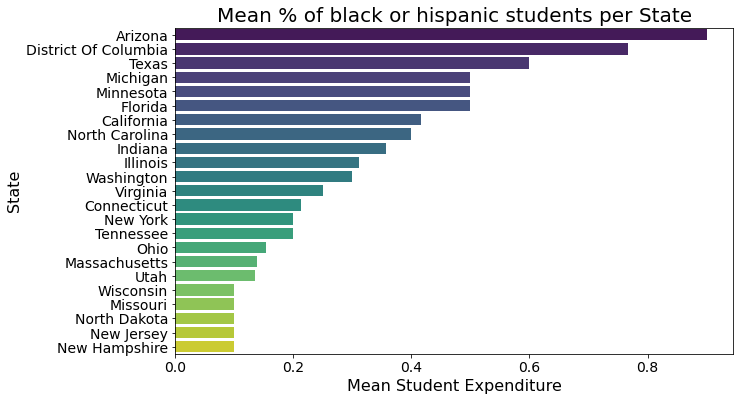

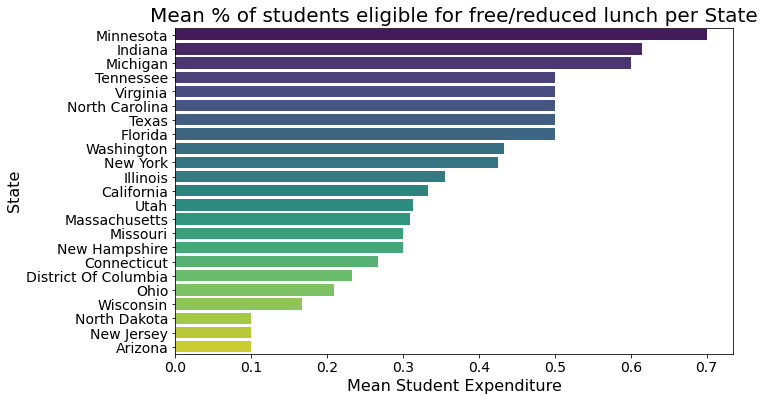

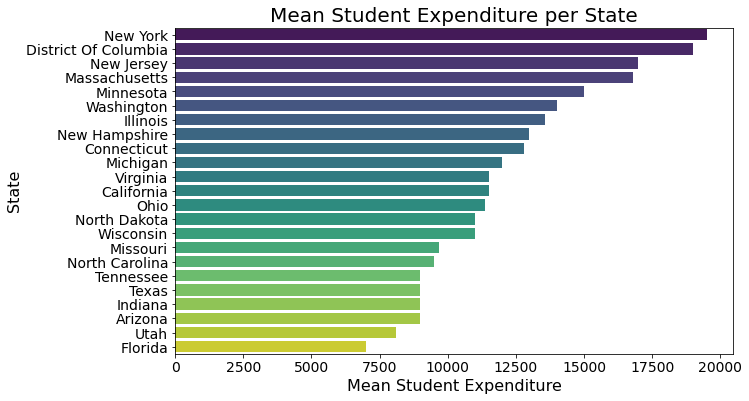

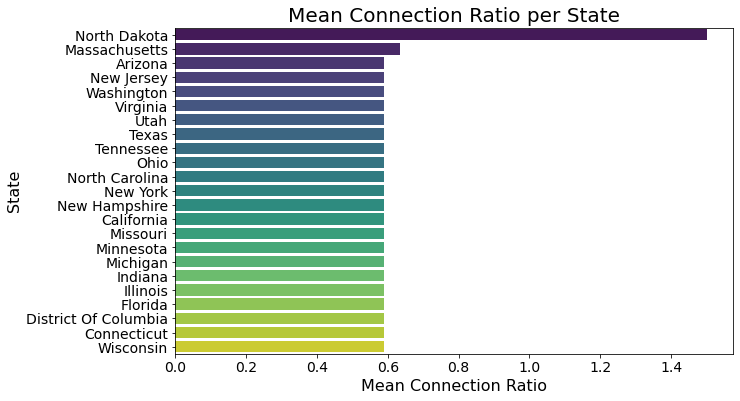

In [41]:
plot_bar1(df_dist1,'avg_pct_black/hispanic','state','Mean % of black or hispanic students per State','Mean Student Expenditure','State')
plot_bar1(df_dist1,'avg_pct_free/reduced','state','Mean % of students eligible for free/reduced lunch per State','Mean Student Expenditure','State')
plot_bar1(df_dist1,'avg_pp_total_raw','state','Mean Student Expenditure per State','Mean Student Expenditure','State')
plot_bar1(df_dist1,'avg_county_connections_ratio','state','Mean Connection Ratio per State','Mean Connection Ratio','State')

Above distributions could be significantly affected by the outliers. What we had in dataset was min and max and here we have plotted the average of two for all the above plots.  But we don't know the distribution between the ranges and hence any outlier can affect the above plots and the conclusions significantly.

### Conclusion:
* The top three states with the highest number of black/hispanic students are Arizona, District of Columbia,Texas. The least number of black/hispanic students are in Wisconsin,Missouri,New Jersey,North Dakota, New Hampshire.
* A high percentage of students in Minnesota, Indiana,Michigan are eligible to receive free or reduced lunch.
* The top three states in average expenditure per student are in the following states: New York, District of Columbia and New Jersey while the lowest expenditure is in Florida and Utah.
* North Dakota a significantly higher average speed of connection compared to the other states followed by Massachussets. The average speed of connection in all the other states is the same.


**Summary:**

General Insights:
* Dataset contains most number of school districts for <span style='color:red'> Connecticut </span> state (17%).
* <span style='color:red'>Suburbs</span> is the most common (59%) locale type for the districts in the dataset.
* <span style='color:red'>Arizona </span> has the highest percentage of black/hispanic students.
* The percentage of students receiving free/reduceed lunch is highest in <span style='color:red'>Minnesota</span>, and lowest in <span style='color:blue'>New Jersey</span>,<span style='color:blue'>Arizona</span>, <span style='color:blue'>North Dakota</span>.
* The expenditure per student is highest in <span style='color:red'>New York</span> state and lowest in <span style='color:blue'>Florida</span>.
* <span style='color:red'>North Dakota</span> and <span style='color:blue'>Massacheusetts</span> have a significantly higher connectivity ratio compared to other states. 


## **Products Data:**

**Group by Provider/Company Name**

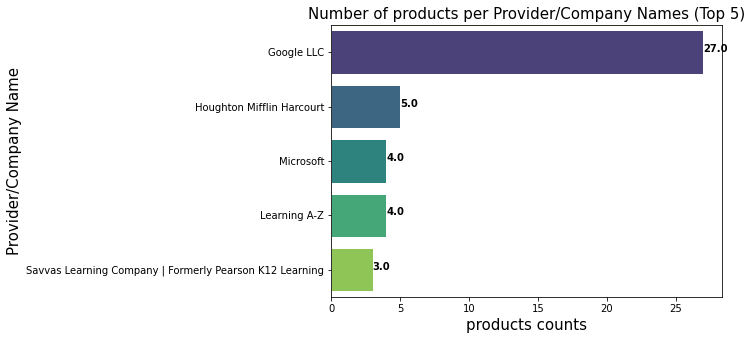

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(7,5), sharey=True)
sns.countplot(y = 'Provider/Company Name', 
              data = df_prod_x, 
              edgecolor="white",
              palette="viridis",#"rocket_r",
              order = df_prod['Provider/Company Name'].value_counts().index[:5])

for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f"% rect.get_width(), weight='bold' )
 
 ###
plt.xticks(size=10)
plt.yticks(size=10)
plt.ylabel("Provider/Company Name",size=15)
plt.xlabel("products counts",size=15)
plt.title('Number of products per Provider/Company Names (Top 5)',size=15)

plt.show()

* Google LLC is the top provider with a significantly large margin compared to other product providers. This is understandable because it provides a large number of leading products that encourage digital learning.

Let's visualize the product names in the word cloud. The bigger and bolder the word appears, more is its frequency in top 352 products

Provider/Company Names 


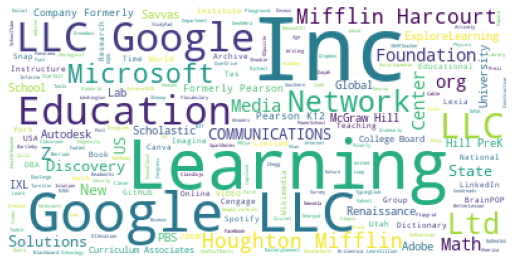





 Product Names 


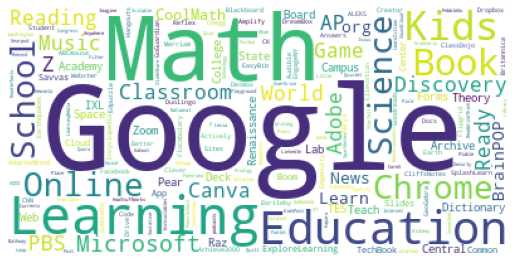

In [43]:
print('Provider/Company Names ')
cloud = WordCloud(max_words=500,background_color="white").generate(" ".join(df_prod_x['Provider/Company Name'].astype(str)))
plt.figure(figsize=(9,20))
plt.imshow(cloud)
plt.axis('off')
plt.show()

print('\n\n\n\n Product Names ')
cloud = WordCloud(max_words=1000,background_color="white").generate(" ".join(df_prod_x['Product Name'].astype(str)))
plt.figure(figsize=(9,20))
plt.imshow(cloud)
plt.axis('off')
plt.show()

## Google is the leader here. No surprises !!

**Sectors Distribution**

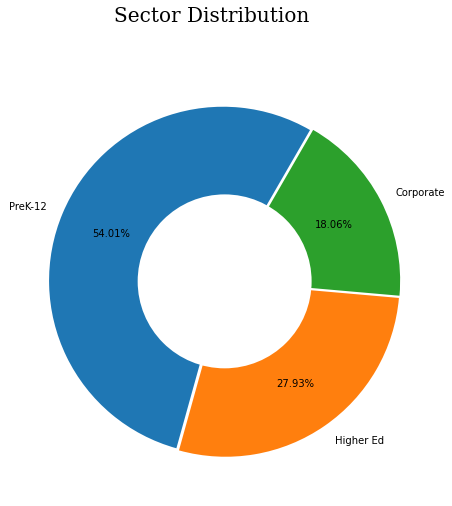

In [44]:
s1=0
s2=0
s3=0
for s in df_prod["Sector(s)"]:
    if(not pd.isnull(s)):
        s = s.split(";")
        for i in range(len(s)):
            sub = s[i].strip()
            if(sub == 'PreK-12'): 
                s1=s1+1
            if(sub == 'Higher Ed'): 
                s2=s2+1
            if(sub == 'Corporate'): 
                s3=s3+1

fig, ax  = plt.subplots(figsize=(14, 8))
fig.suptitle('Sector Distribution', font="Serif",fontsize=20)
explode = (0.01, 0.01, 0.01)#,0.01,0.01)
#labels = list(df_prod["Sector(s)"].value_counts().index)
#sizes = df_prod["Sector(s)"].value_counts().values
labels = ['PreK-12','Higher Ed','Corporate']
sizes = [s1,s2,s3]
ax.pie(sizes,
       startangle=60,
       explode=explode, 
       labels=['PreK-12','Higher Ed','Corporate'],
       autopct='%1.2f%%', 
       pctdistance=0.7)
ax.add_artist(plt.Circle((0,0),0.5,fc='white'))
plt.show()

* PreK-12 Sector use highest number of products (54%) followed by Higher Ed sector (28%).

**Primary Essential Function**

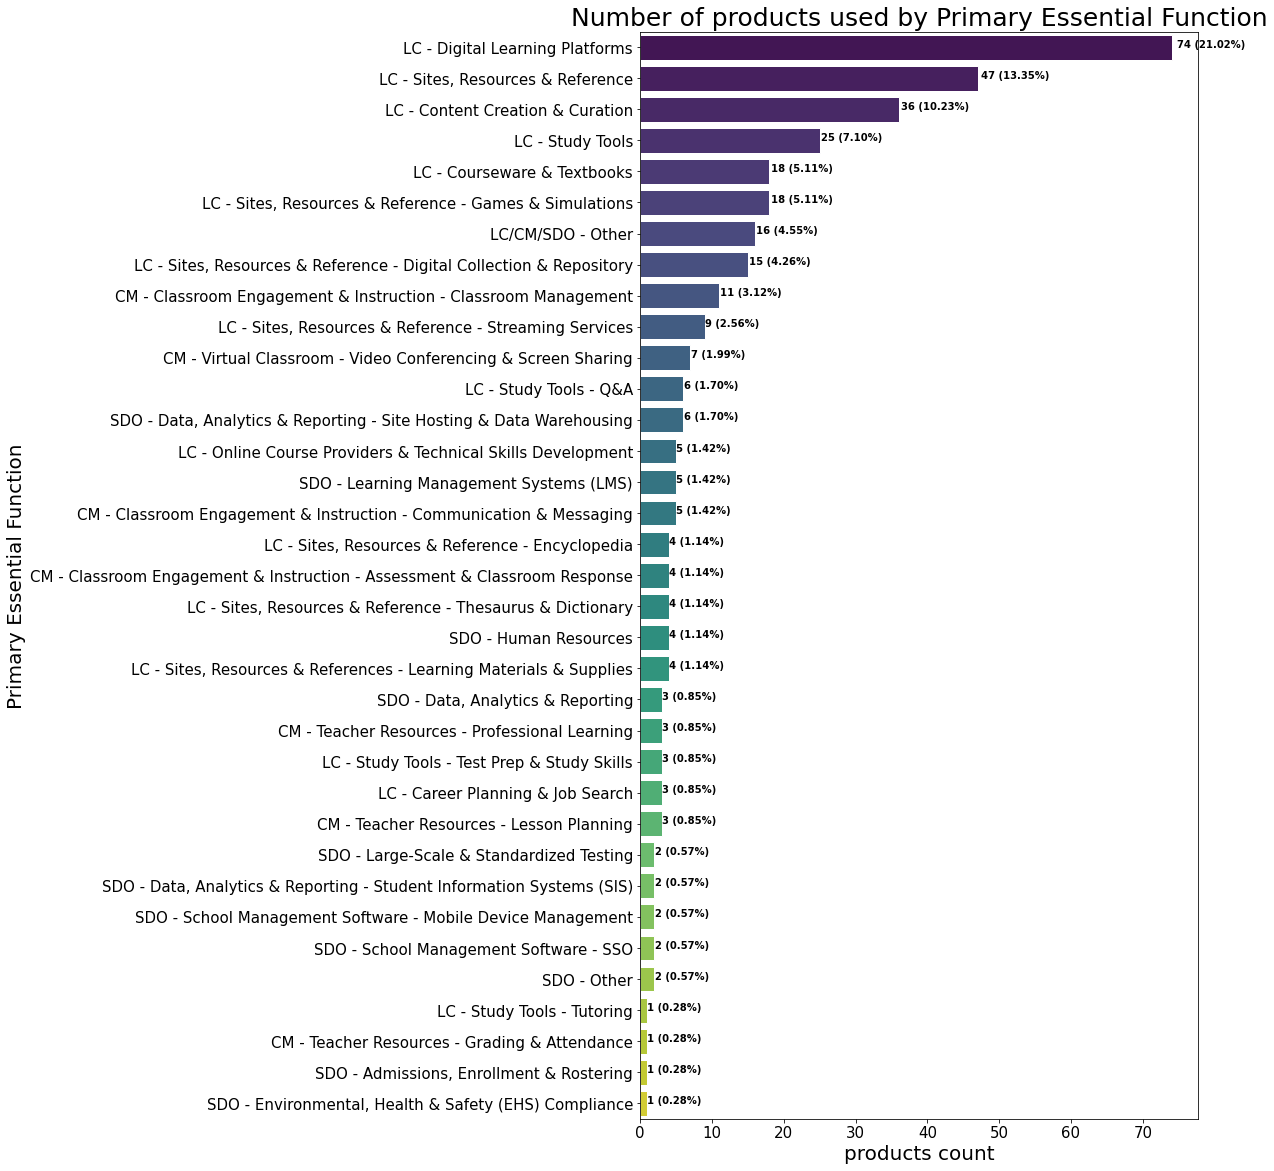

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10,20), sharey=True)
sns.countplot(y = 'Primary Essential Function', 
              data = df_prod_x, 
              edgecolor="white",
              palette="viridis",
              order = df_prod['Primary Essential Function'].value_counts().index)
 

total = df_prod_x["Primary Essential Function"].value_counts().sum()
for i, v in enumerate(df_prod_x["Primary Essential Function"].value_counts().sort_values(ascending=False).values): 
    frac1 = (v/total)*100
    frac = "{:.2f}".format(frac1)
    v1 = str(v)+' ('+str(frac)+'%)'
    ax.text(v*1.01, i, v1,fontsize=10,color='black',weight='bold')
    
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylabel("Primary Essential Function",size=20)
plt.xlabel("products count",size=20)
plt.title('Number of products used by Primary Essential Function',size=25)

plt.show()

* Top three catagories are **Digital learning platforms**, **Site, Resources and References** and **Content creation and curation**.
* The LC (learning curriculum) category has the highest percentage of products.

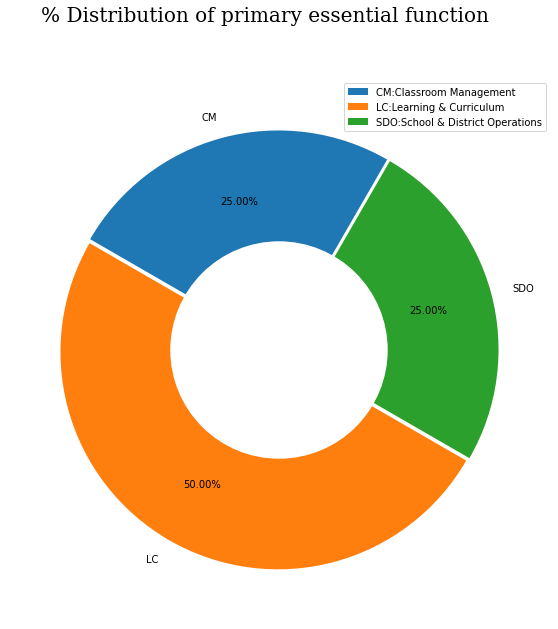

In [46]:
s1=0
s2=0
s3=0
for s in df_prod_x["Primary Essential Function"]:
    if(not pd.isnull(s)):
        s1 = s.count("CM")+1
        s2 = s.count("LC")+1
        s3 = s.count("SDO")+1

fig, ax  = plt.subplots(figsize=(16, 10))
fig.suptitle('% Distribution of primary essential function', font="Serif",fontsize=20)
explode = (0.01, 0.01, 0.01)#,0.01,0.01)
labels = ['CM','LC','SDO']
sizes = [s1,s2,s3]
ax.pie(sizes,
       startangle=60,
       explode=explode, 
       labels=labels,
       autopct='%1.2f%%', 
       pctdistance=0.7)
ax.add_artist(plt.Circle((0,0),0.5,fc='white'))
subgroup_names_legs=['CM:Classroom Management', 'LC:Learning & Curriculum', 'SDO:School & District Operations']
plt.legend(subgroup_names_legs,loc='best')
plt.show()

* From all types of different learning tools, around 50% of the total products used by students are for **LC**. 

Since, the primary essential function column of the product dataset has two layers of labels here. Products are first labeled as one of these three categories: **LC = Learning & Curriculum, CM = Classroom Management, and SDO = School & District Operations**. Each of these categories have multiple sub-categories with which the products were labeled. So, we will split this column into primary_function_main and primary_function_sub columns respectively to understand the distribution of products.

In [47]:
#Subdivide primary essential function
df_prod_y=df_prod_x
df_prod_y['primary_function_main'] = df_prod_y['Primary Essential Function'].apply(lambda x: x.split(' - ')[0] if x == x else x)
df_prod_y['primary_function_sub'] = df_prod_y['Primary Essential Function'].apply(lambda x: x.split(' - ')[1] if x == x else x)

# Synchronize similar values
df_prod_y['primary_function_sub'] = df_prod_y['primary_function_sub'].replace({'Sites, Resources & References' : 'Sites, Resources & Reference'})
# Deleting the 'Primary Essential Function' column from the product dataset as it is no longer needed since we already have split it into two sub-columns.
df_prod_y.drop("Primary Essential Function", axis=1, inplace=True)

## **Engagement Data:**

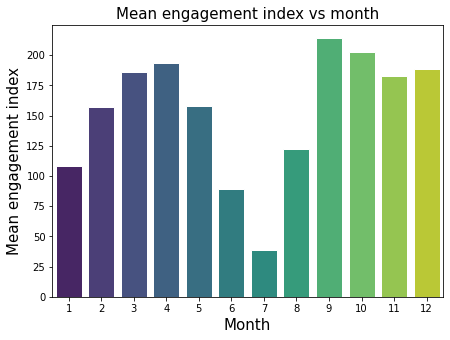

In [48]:
df_engagement['time'] = pd.to_datetime(df_engagement['time'])
df_engagement['month'] = df_engagement['time'].dt.month

fig, ax = plt.subplots(1, 1, figsize=(7,5), sharey=True)
sns.barplot(x = 'month',y='engagement_index', 
              data = df_engagement.groupby(df_engagement['month']).mean().reset_index(), 
              edgecolor="white",
              palette="viridis")


plt.title('Mean engagement index vs month',size=15)
plt.xlabel("Month",size=15)
plt.ylabel("Mean engagement index",size=15)
plt.show()

* There is a steady increase in engagement levels from January to April 2020. This might be due to stricter lockdowns thrroughout USA as we advanced forward in 2020.

* The engagement index had improved over the course of 2020, with a significant dip in June and July before picking up again in August. 

* This might be due to the 12 weeks summer break in USA beginning between Mid May - Mid August. September was the month with the highest mean engagement index.

* From August onwards, the level of engagement is seen to be going up and even higher than spring of 2020. This makes sense because schools,institutions and even corporates started using online platforms for learning and started working from home more consistently.

## **Combined Data**
* combining the three datasets, product data , district data and engagement data 

In [49]:
#combine three tables together based on common column identifiers
df_engagement_x['lp_id'] = df_engagement_x['lp_id'].astype('int')
df_engagement_x['district_id'] = df_engagement_x['district_id'].astype('int')

# merging engagement and district data based on district id 
Data = pd.merge(df_engagement_x,df_dist_x,how='left',on='district_id')

# merging above data with prod data based on LP ID (unique product identifier)
Data = pd.merge(Data,df_prod_y,how='left',left_on='lp_id',right_on='LP ID')

In [50]:
#dropping missing values from the dataset
#Data.dropna(axis=0,how='any',inplace=True)
Data = Data[Data["LP ID"].notna()].reset_index(drop=True)

In [51]:
Data.head()

time  lp_id  pct_access  engagement_index  district_id  \
0  2020-01-01  92844        0.01          0.680000         6345   
1  2020-01-01  64838        0.01          0.680000         6345   
2  2020-01-01  94058        0.00        167.610644         6345   
3  2020-01-01  95731        0.20         40.960000         6345   
4  2020-01-01  83862        0.01          0.110000         6345   

           state  locale  min_pct_black/hispanic  max_pct_black/hispanic  \
0  Massachusetts  Suburb                     0.2                     0.4   
1  Massachusetts  Suburb                     0.2                     0.4   
2  Massachusetts  Suburb                     0.2                     0.4   
3  Massachusetts  Suburb                     0.2                     0.4   
4  Massachusetts  Suburb                     0.2                     0.4   

   min_pct_free/reduced  ...  avg_pct_free/reduced  avg_pp_total_raw  \
0                   0.2  ...                   0.3           13000.0   
1                   0.2  ...                   0.3           13000.0   
2                   0.2  ...                   0.3           13000.0   
3                   0.2  ...                   0.3           13000.0   
4                   0.2  ...                   0.3           13000.0   

   avg_county_connections_ratio    LP ID                          URL  \
0                          0.59  92844.0      https://www.typing.com/   
1                          0.59  64838.0     http://www.starfall.com/   
2                          0.59  94058.0  https://www.coursehero.com/   
3                          0.59  95731.0      http://docs.google.com/   
4                          0.59  83862.0     http://www.raz-kids.com/   

   Product Name  Provider/Company Name                      Sector(s)  \
0    Typing.com           Teaching.com  PreK-12; Higher Ed; Corporate   
1      Starfall     Starfall Education                        PreK-12   
2   Course Hero            Course Hero             PreK-12; Higher Ed   
3   Google Docs             Google LLC  PreK-12; Higher Ed; Corporate   
4      Raz-Kids           Learning A-Z                        PreK-12   

   primary_function_main          primary_function_sub  
0                     LC    Digital Learning Platforms  
1                     LC  Sites, Resources & Reference  
2                     LC                   Study Tools  
3                     LC   Content Creation & Curation  
4                     LC    Digital Learning Platforms  

[5 rows x 26 columns]

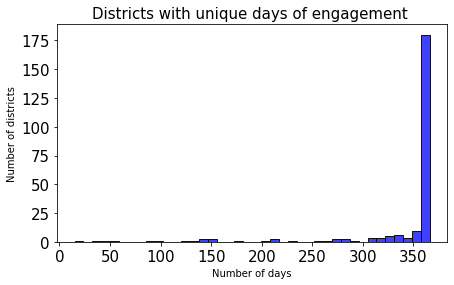

In [52]:
plt.figure(figsize=(7,4))
sns.histplot(Data.groupby('district_id').time.nunique(), bins=40, color = 'blue')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Number of days', fontsize=10)
plt.ylabel('Number of districts', fontsize=10)
plt.title('Districts with unique days of engagement ', fontsize = 15)

plt.show()

**Conclusion**
* From the above histogram, we can see that majority of districts have engagement data for 366 days (2020) while some of them have data for less than 10 days.

To see the ones with very small statistics lets remake above plot with y axis in log scale

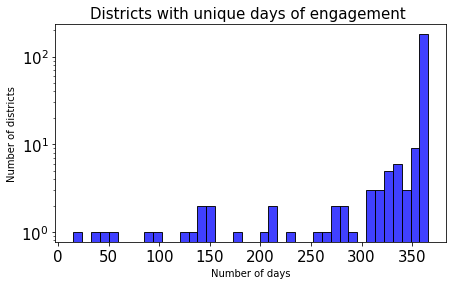

In [53]:
plt.figure(figsize=(7,4))
sns.histplot(Data.groupby('district_id').time.nunique(), bins=40, color = 'blue')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Number of days', fontsize=10)
plt.ylabel('Number of districts', fontsize=10)
plt.title('Districts with unique days of engagement ', fontsize = 15)
plt.yscale('log')
plt.show()

* Plotting below Mean engagement index and pct access per state.
* We only make the plot for engagement with primary function as LC (Learning and curriculum).
* LC is the primary function type where we expect mostly student engagement 

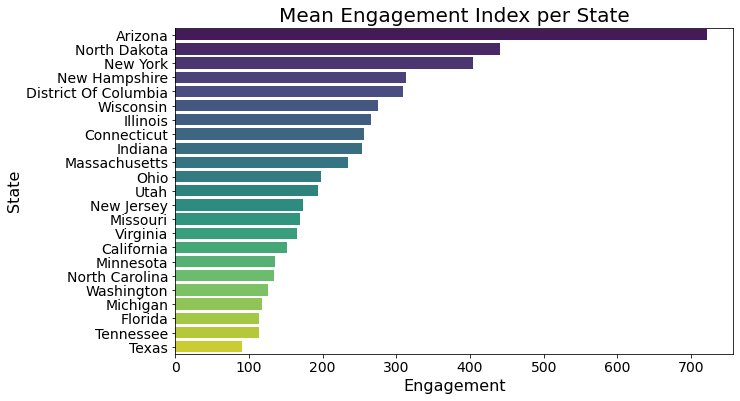

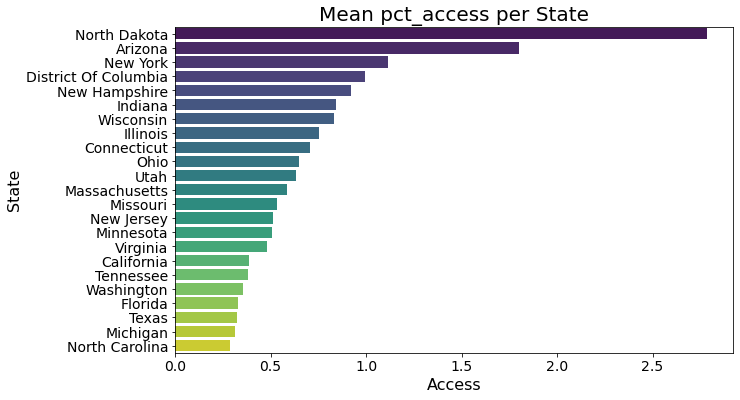

In [54]:
# selecting data set including entries for only primary function as LC (most student engagement expected here)
Datax=Data.loc[((Data["Sector(s)"]=="PreK-12")|(Data["Sector(s)"]=="PreK-12; Higher Ed")|(Data["Sector(s)"]=="PreK-12; Higher Ed; Corporate"))&(Data["primary_function_main"]=="LC")]

# grouping data state wise and storing the mean of certain columns 
state_eng=pd.DataFrame(Datax.groupby('state')[['engagement_index','avg_pp_total_raw','avg_pct_black/hispanic','avg_pct_free/reduced']].mean().sort_values(['engagement_index','avg_pp_total_raw','avg_pct_black/hispanic','avg_pct_free/reduced'],ascending=False))
state_eng=state_eng.reset_index()
plot_barh(state_eng,'engagement_index','state','Mean Engagement Index per State','Engagement','State')

state_access=pd.DataFrame(Datax.groupby('state')[['pct_access','avg_pp_total_raw','avg_pct_black/hispanic','avg_pct_free/reduced']].mean().sort_values(['pct_access','avg_pp_total_raw','avg_pct_black/hispanic','avg_pct_free/reduced'],ascending=False))
state_access=state_access.reset_index()
plot_barh(state_access,'pct_access','state','Mean pct_access per State','Access','State')

### Conclusion
* Arizona, North Dakota, New York and New Hampshire were the top 4 states in terms of mean engagement index.
*  North Dakota,Arizona, New York and District of columbia were the top 4 states in terms of mean pct access.

****Q: How does student engagement with different types of education technology change over the course of the pandemic? ****

To answer this let's look at  three categories of primary function type main i.e
* LC : Learning and curriculum
* SDO : school and district operations
* CM : classroom management

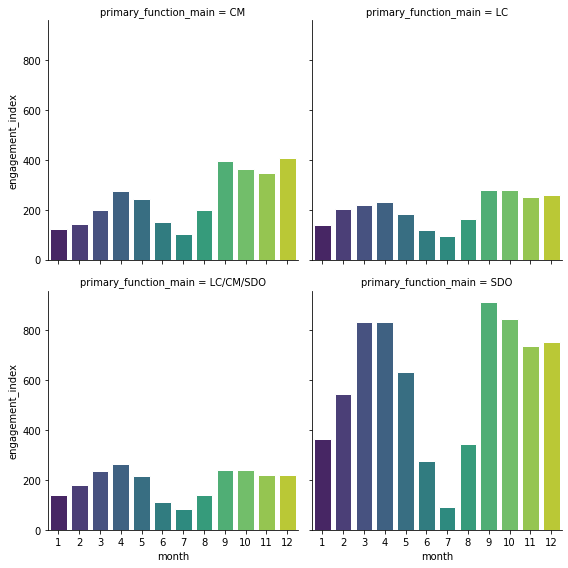

In [55]:
# for our plot we only need following columns: time, engagement_index, primary_function_main 
Data['time'] = pd.to_datetime(Data['time'])
Data['month'] = Data['time'].dt.month

sns.catplot(x = 'month',y='engagement_index', 
              data = Data.groupby(by=['month','primary_function_main']).mean().reset_index(), 
              edgecolor="white",kind='bar',
              palette="viridis",col='primary_function_main',col_wrap=2,height=4)


plt.show()

### Conclusion
* Engagement index for Primary function type SDO: School and district operations was significantly higher then other function type
* Monthly pattern is similar for all primary function types: Fall 2020 engagement was higher than spring 2020
* Drop in engagement during summer break as expected 
* For category LC , which is where students engagement is most showed a higher engagement during Fall 2020 compared to spring 2020.

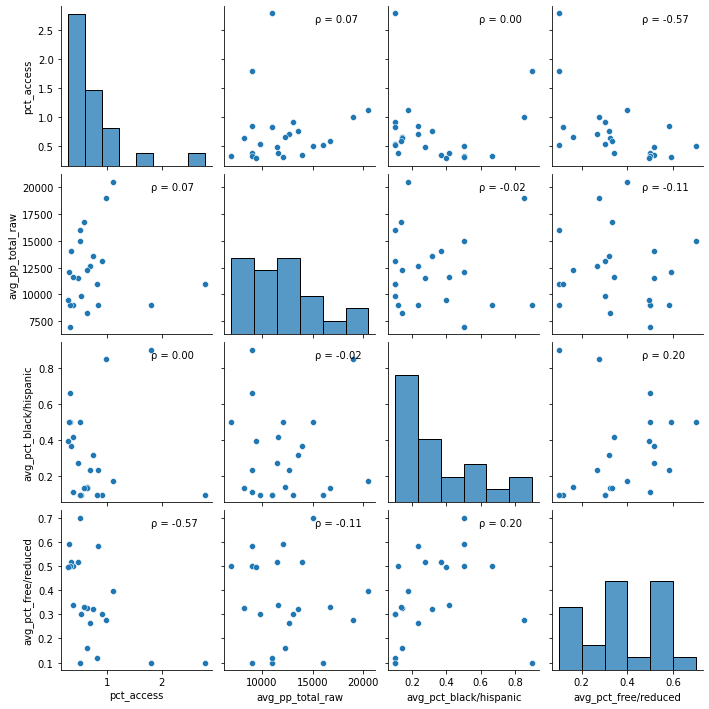

In [56]:
# lets check the correlation between different features of data or variables , 
# pct access, expenditure, black/hispanic, free/reduced lunch eligibility %
g = sns.pairplot(state_access)

# let's show pearson correlation coefficient (https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) 
#above each pair plot 
from scipy.stats import pearsonr
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.6, .9), xycoords=ax.transAxes)

g.map_offdiag(corrfunc)
plt.show()

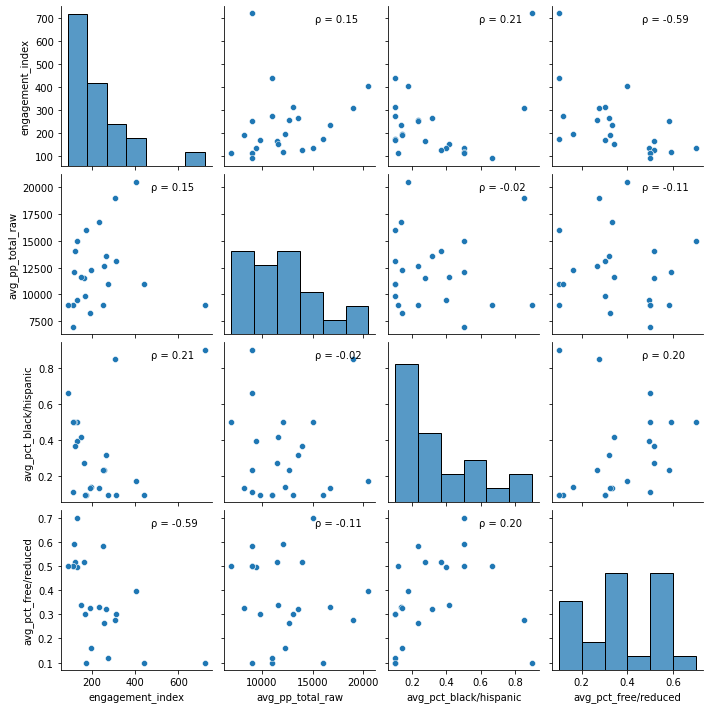

In [57]:
# lets study the engagement correlation with 
g=sns.pairplot(state_eng)
g.map_offdiag(corrfunc)
plt.show()

## Conclusion
* Engagement Index has a positive correlation with avg_pp_total_raw (total expenditure per pupil). Make sense if the expenditure is aimed at increasing digital learning we expect the engagement to increase with expenditure.
* There is a strong negative correlation between engagement index and avg_pct_free/reduced i.e. as more people qualify for free/reduced lunch in a school district the average index drops. Free/reduced lunch qualification depends on poor economic status. So this might be due to poor people can't afford the infrastructure required for engagement in digital learning 

* avg students that indentify as black/hispanic increases as the number of people qualifying for free lunch increases. This is probably due to black and hispanic communities being financial poor compared to other communities in USA. 

* We can also conclude that black/hispanic communities also have lower engagement index

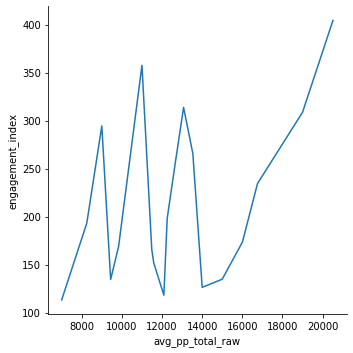

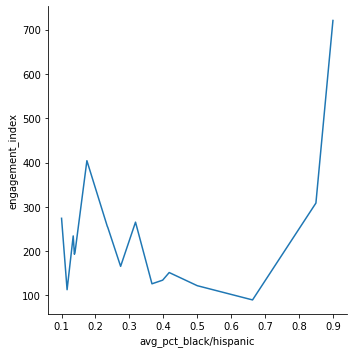

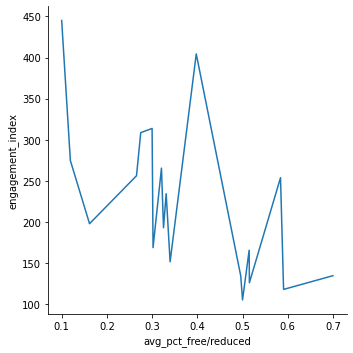

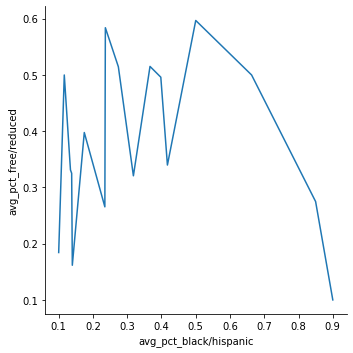

In [58]:
sns.relplot(x="avg_pp_total_raw", y="engagement_index", kind="line", data=state_eng,ci=None)
sns.relplot(x="avg_pct_black/hispanic", y="engagement_index", kind="line", data=state_eng,ci=None)
sns.relplot(x="avg_pct_free/reduced", y="engagement_index", kind="line", data=state_eng,ci=None)
sns.relplot(x="avg_pct_black/hispanic", y="avg_pct_free/reduced", kind="line", data=state_eng,ci=None)

### Conclusion:
* **Interesting !** , If communities are dominantly black/hispanic i.e. if there percentage is greater than 50% or 60%, the trends are opposite to when its below 50 % for example
* In free/rreduced lunch vs % black and hispanic plot , there is positive trend until 50% black/hispanic population and if it above 60% they no more need free/reduced lunch.
* Same is the trend for engagement index vs avg_pct_black/hispanic plot , if the community is dominantly black then the engagement is much higher compared to when they are minority 

**Reasons for this , are above conlusions correct ???**

### Studying the engagement as function of school districts locale type 
(only for primary function type as LC)

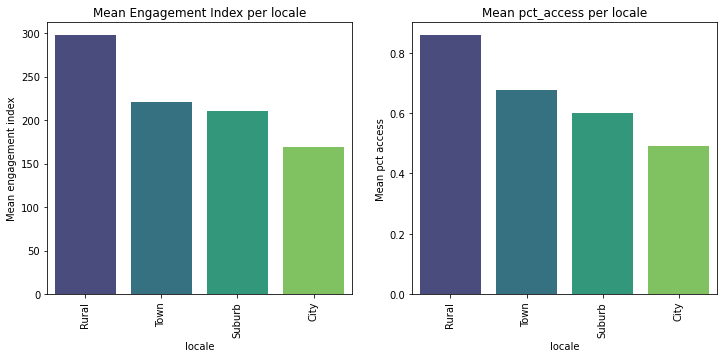

In [59]:
locale_eng=pd.DataFrame(Datax.groupby('locale')['engagement_index'].mean().sort_values(ascending=False))
locale_eng=locale_eng.reset_index()
locale_access=pd.DataFrame(Datax.groupby('locale')['pct_access'].mean().sort_values(ascending=False))
locale_access=locale_access.reset_index()

plot_bar2(locale_eng,'locale','engagement_index','Mean Engagement Index per locale','locale','Mean engagement index',locale_access,'pct_access','Mean pct_access per locale','locale','Mean pct access')

* The engagement with digital learning is higher for rural followed by town, suburb and then city 
* opposite of expected as cities are expected to have better infrastructure??
* but the most money was spend in rural areas  ??

### Let's study the engagement for specific products , so we will plot mean engagement and pct access for top10 most popular and least popular product names

(only for LC product type)

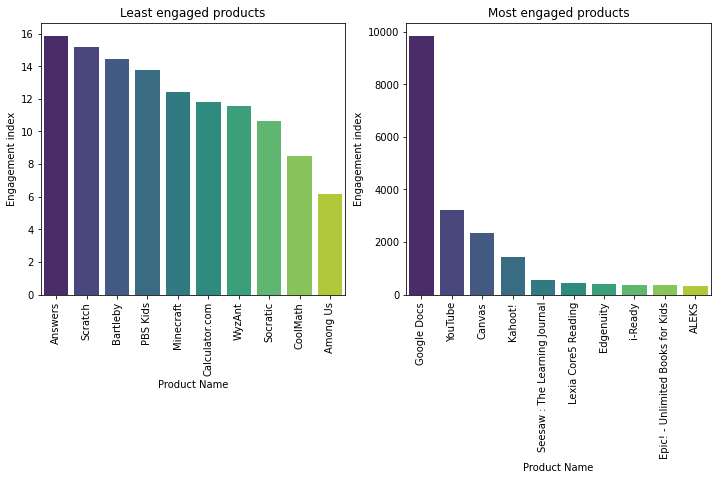

In [60]:
product_eng=pd.DataFrame(Datax.groupby('Product Name')['engagement_index'].mean().sort_values(ascending=False))
product_eng=product_eng.reset_index()
product_eng_large=product_eng[["engagement_index","Product Name"]].head(10)
product_eng_least=product_eng[["engagement_index","Product Name"]].tail(10)
#plot_barh(product_eng_large,'engagement_index','Product Name','Most engaged products','Product Name','Engagement')
#plot_barh(product_eng_least,'engagement_index','Product Name','Least engaged products','Product Name','Engagement')
plot_bar2(product_eng_least,'Product Name','engagement_index','Least engaged products','Product Name','Engagement index',product_eng_large,'engagement_index','Most engaged products','Product Name','Engagement index')

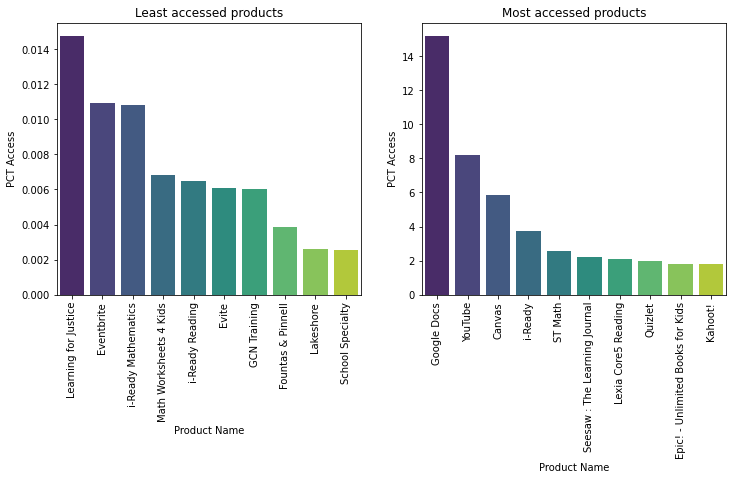

In [61]:
product_access=pd.DataFrame(Datax.groupby('Product Name')['pct_access'].mean().sort_values(ascending=False))
product_access=product_access.reset_index()
product_access_large=product_access[["pct_access","Product Name"]].head(10)
product_access_least=product_access[["pct_access","Product Name"]].tail(10)

plot_bar2(product_access_least,'Product Name','pct_access','Least accessed products','Product Name','PCT Access',product_access_large,'pct_access','Most accessed products','Product Name','PCT Access')

*** Google Docs, You Tube and Canvas had the highest engagement index and pct access for LC function**

In [62]:
st_acсess = Data.groupby(['state', 'time']).agg({'pct_access': 'mean'}).sort_values(['pct_access'],ascending=False).reset_index()
st_eng = Data.groupby(['state', 'time']).agg({'engagement_index': 'mean'}).sort_values(['engagement_index'],ascending=False).reset_index()
loc_acсess = Data.groupby(['locale', 'time']).agg({'pct_access': 'mean'}).sort_values(['pct_access'],ascending=False).reset_index()
loc_eng = Data.groupby(['locale', 'time']).agg({'engagement_index': 'mean'}).sort_values(['engagement_index'],ascending=False).reset_index()
cat_acсess = Data.groupby(['primary_function_main', 'time']).agg({'pct_access': 'mean'}).sort_values(['pct_access'],ascending=False).reset_index()
cat_eng = Data.groupby(['primary_function_main', 'time']).agg({'engagement_index': 'mean'}).sort_values(['engagement_index'],ascending=False).reset_index()


for i in [st_acсess, st_eng, loc_acсess, loc_eng, cat_acсess, cat_eng]:
    i['time'] = pd.to_datetime(i['time'], errors='coerce')
    i['day_of_week'] = i['time'].dt.dayofweek
    i['month'] = i['time'].dt.month

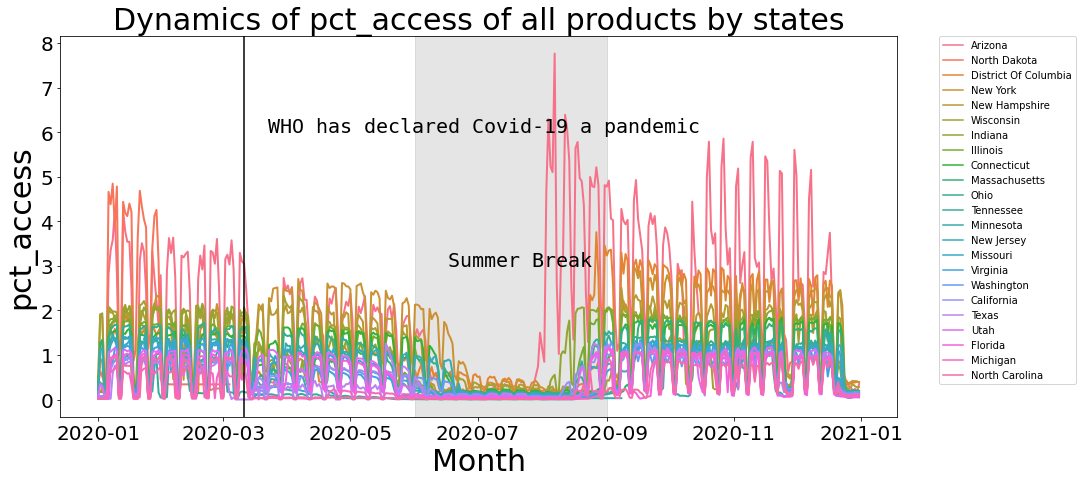

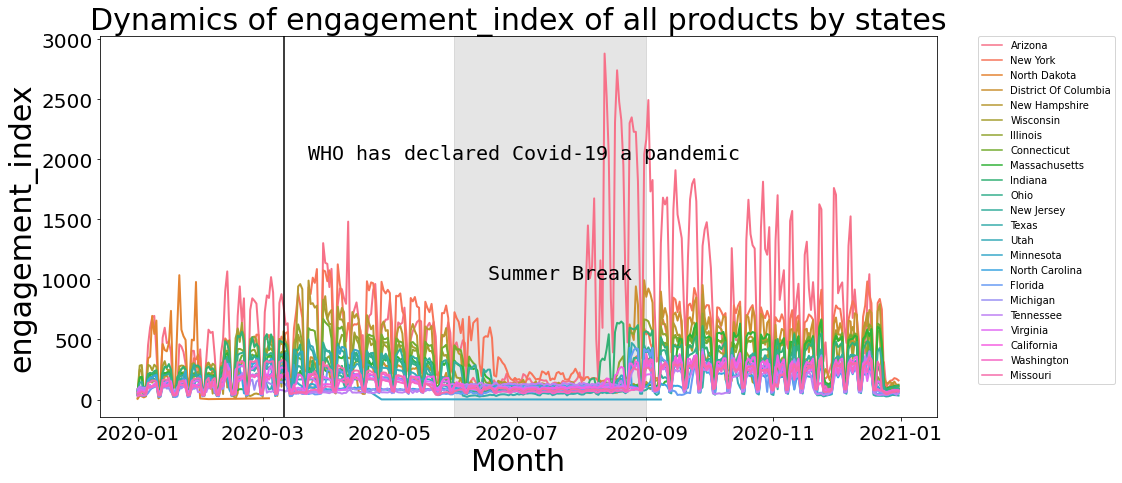

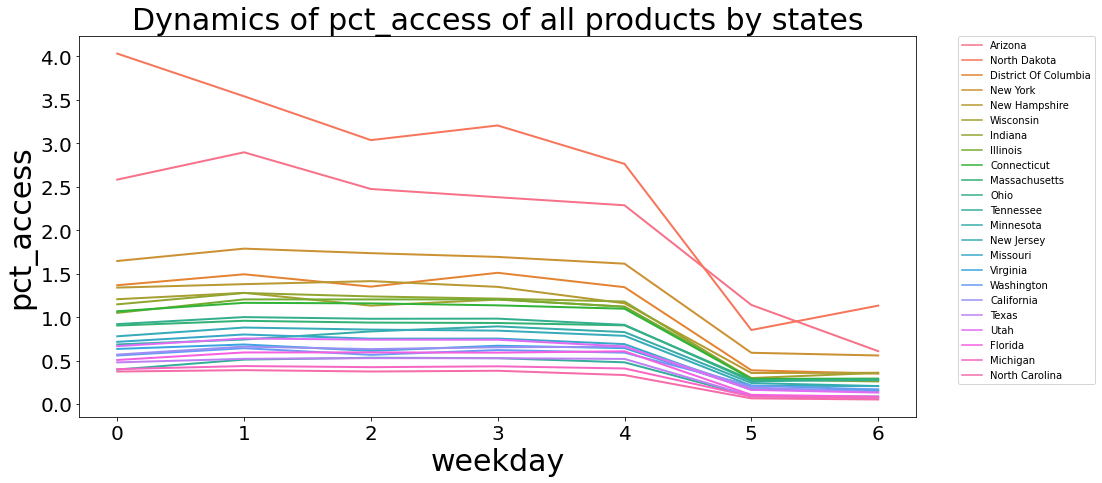

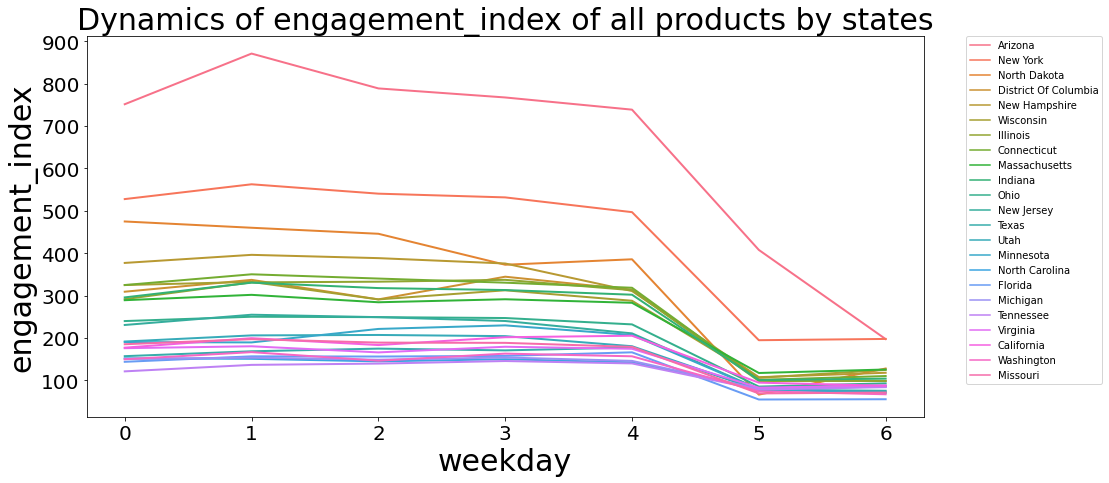

In [63]:
plot_line(st_acсess,"time","pct_access","state","Dynamics of pct_access of all products by states","Month","pct_access",6,3)
plot_line(st_eng,"time","engagement_index","state","Dynamics of engagement_index of all products by states","Month","engagement_index",2000,1000)

#plot_line_day(st_acсess,"month","pct_access","state","Dynamics of pct_access of all products by states","Month","pct_access",6,3)
#plot_line_day(st_eng,"month","engagement_index","state","Dynamics of engagement_index of all products by states","Month","engagement_index",2000,1000)

plot_line_day(st_acсess,"day_of_week","pct_access","state","Dynamics of pct_access of all products by states","weekday","pct_access",6,3)
plot_line_day(st_eng,"day_of_week","engagement_index","state","Dynamics of engagement_index of all products by states","weekday","engagement_index",2000,1000)

#plot_line_day(st_acсess,"month","pct_access","day_of_week","Dynamics of pct_access of all products by day","Month","pct_access",6,3)
#plot_line_day(st_eng,"month","engagement_index","day_of_week","Dynamics of engagement_index of all products by day","Month","engagement_index",2000,1000)

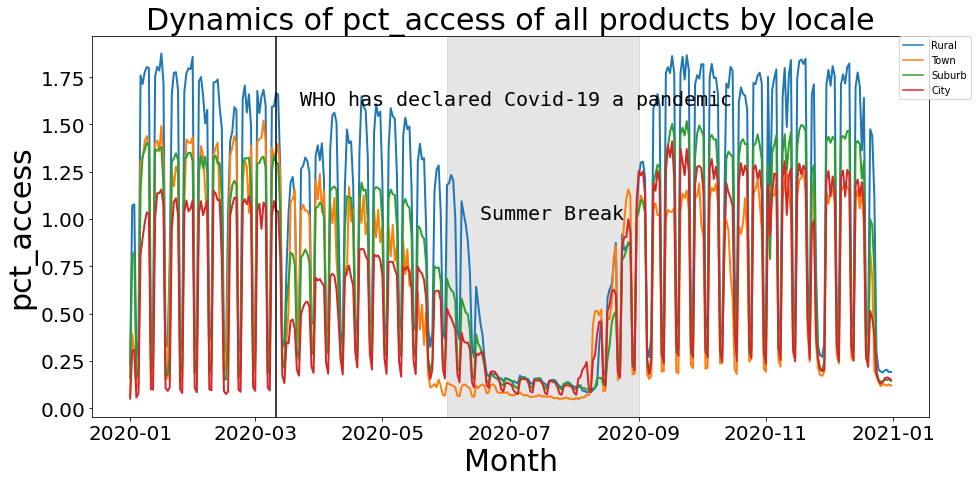

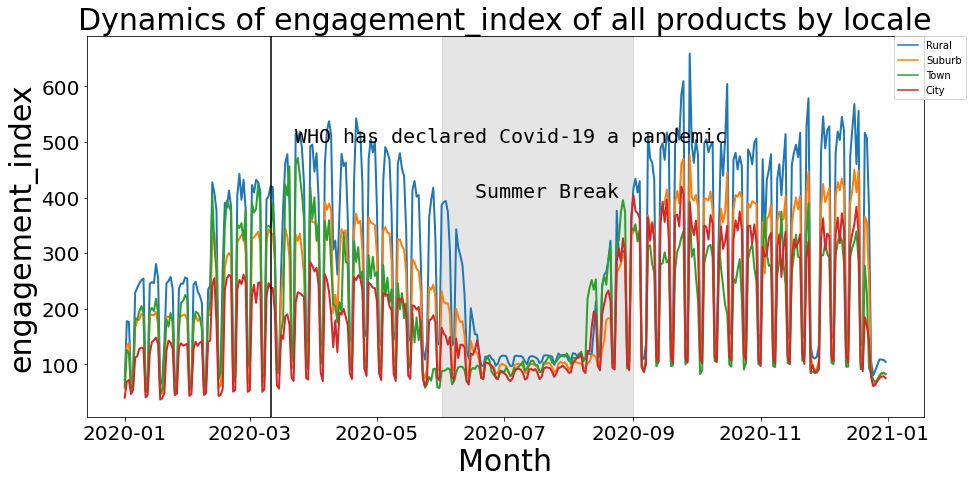

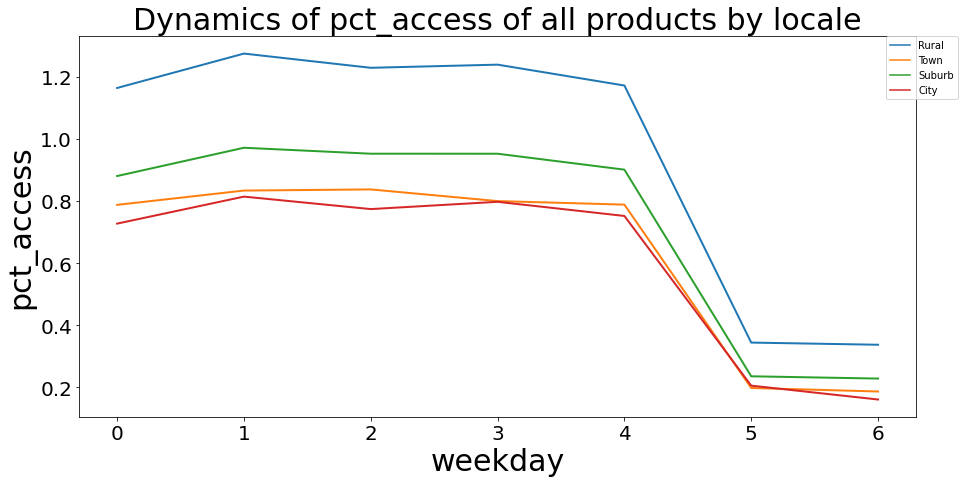

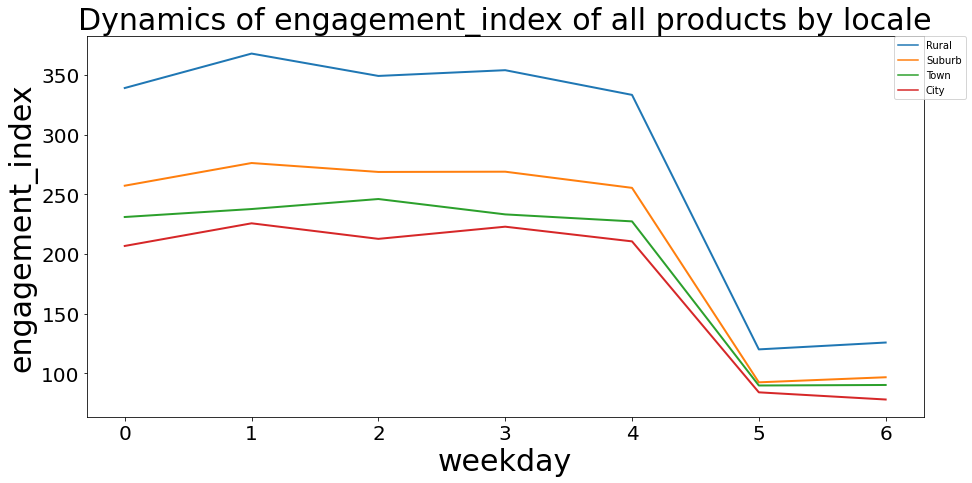

In [64]:
plot_line(loc_acсess,"time","pct_access","locale","Dynamics of pct_access of all products by locale","Month","pct_access",1.6,1)
plot_line(loc_eng,"time","engagement_index","locale","Dynamics of engagement_index of all products by locale","Month","engagement_index",500,400)

#plot_line_day(loc_acсess,"month","pct_access","locale","Dynamics of pct_access of all products by locale","Month","pct_access",1.6,1)
#plot_line_day(loc_eng,"month","engagement_index","locale","Dynamics of engagement_index of all products by locale","Month","engagement_index",500,400)

plot_line_day(loc_acсess,"day_of_week","pct_access","locale","Dynamics of pct_access of all products by locale","weekday","pct_access",6,3)
plot_line_day(loc_eng,"day_of_week","engagement_index","locale","Dynamics of engagement_index of all products by locale","weekday","engagement_index",2000,1000)

#plot_line_day(loc_acсess,"month","pct_access","day_of_week","Dynamics of pct_access of all products by day","Month","pct_access",6,3)
#plot_line_day(loc_eng,"month","engagement_index","day_of_week","Dynamics of engagement_index of all products by day","Month","engagement_index",2000,1000)

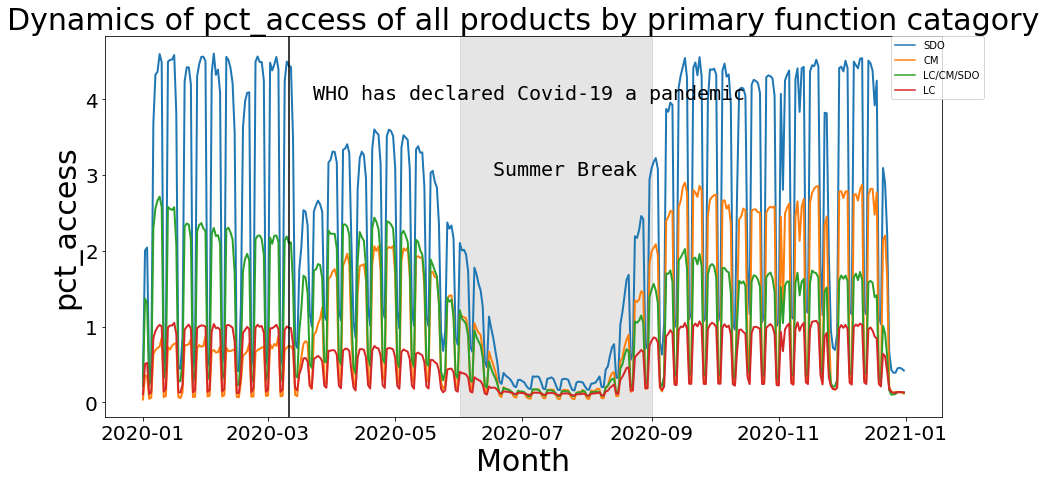

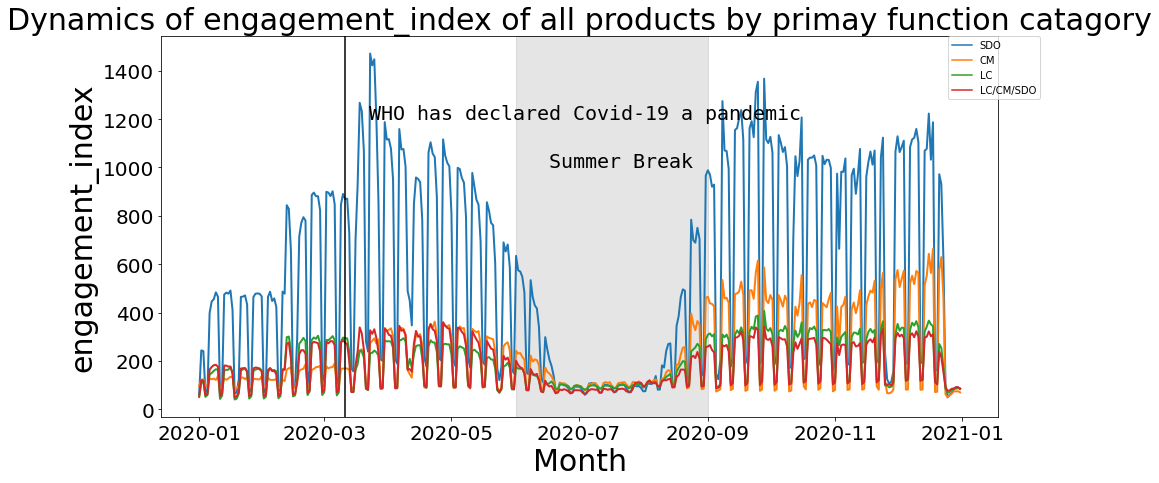

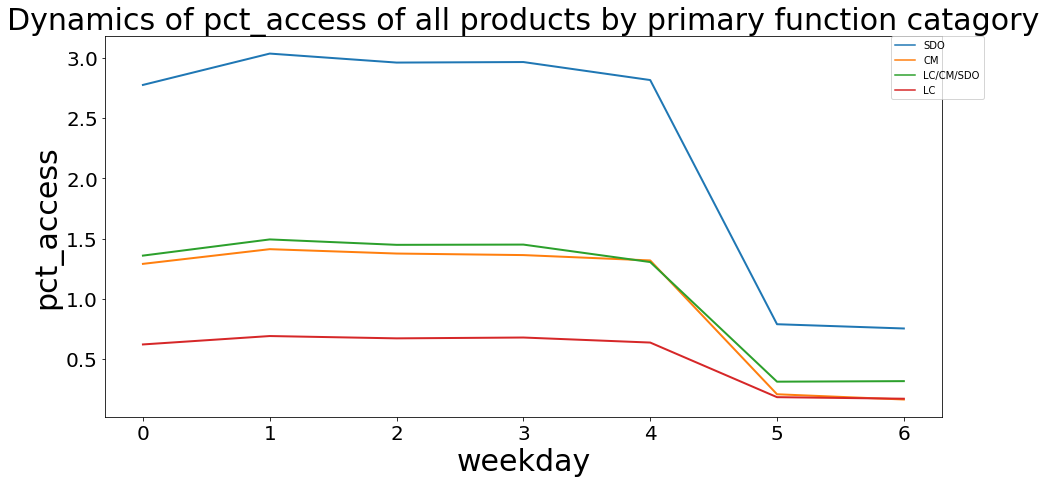

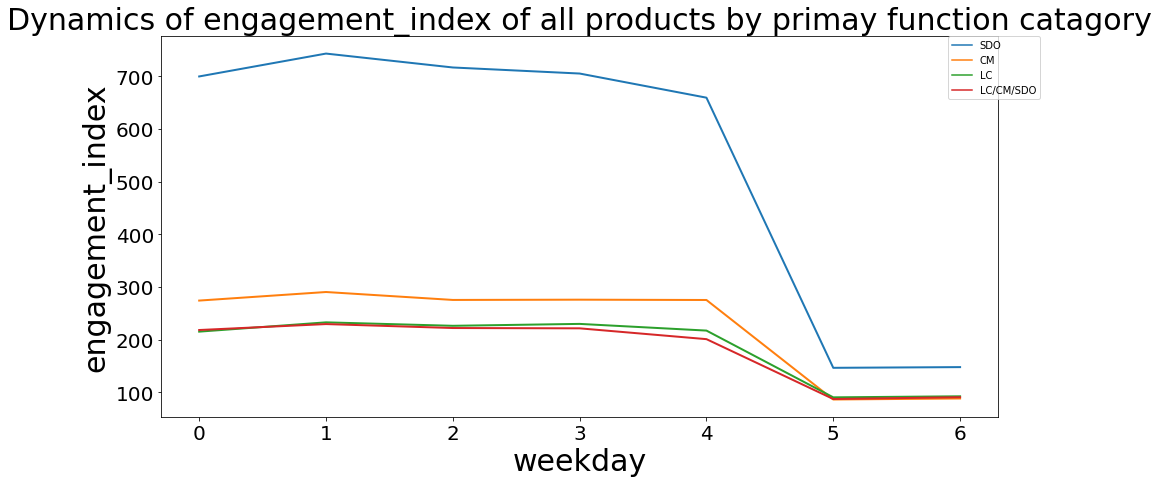

In [65]:
plot_line(cat_acсess,"time","pct_access","primary_function_main","Dynamics of pct_access of all products by primary function catagory","Month","pct_access",4,3)
plot_line(cat_eng,"time","engagement_index","primary_function_main","Dynamics of engagement_index of all products by primay function catagory","Month","engagement_index",1200,1000)

#plot_line_day(cat_acсess,"month","pct_access","primary_function_main","Dynamics of pct_access of all products by primary function catagory","Month","pct_access",4,3)
#plot_line_day(cat_eng,"month","engagement_index","primary_function_main","Dynamics of engagement_index of all products by primay function catagory","Month","engagement_index",1200,1000)

plot_line_day(cat_acсess,"day_of_week","pct_access","primary_function_main","Dynamics of pct_access of all products by primary function catagory","weekday","pct_access",4,3)
plot_line_day(cat_eng,"day_of_week","engagement_index","primary_function_main","Dynamics of engagement_index of all products by primay function catagory","weekday","engagement_index",1200,1000)

#plot_line_day(cat_acсess,"month","pct_access","day_of_week","Dynamics of pct_access of all products by day","Month","pct_access",4,3)
#plot_line_day(cat_eng,"month","engagement_index","day_of_week","Dynamics of engagement_index of all products by day","Month","engagement_index",1200,1000)

**Summary:**

General Insights through out 2020:

**Engagement level of products:**
> * There is a steady increase in engagement levels from January to March 2020. This is because even before COVID-19, there was already high growth and adoption in education technology.
> * Issues such as prolonged closure, uncertainty about the timing of reopening, likely constriction in the academic calendar and the resultant learning discontinuity among students forced the states and educational institutions to find alternative options to assuage the varied impacts. This is where the digital/online learning played a vital role.
> * The engagement index had improved over the course of 2020, fall engagement index was higher than spring. This well understood because schools,institutions and even corporates started using online platforms for learning and working from home.
> * The data clearly shows the sharp drop in engagement index durring summer holidays as expected

> * There is more engagment at the begining of the week then it slowly drops as it gets to the weekend. Tuesday has the highest average engagment.


* **By State:**
> * top most access of products: North Dakota, Arizona, New York and Districts of Coulombia.
> * top most engagement of products: Arizona, North Dakota, New York and New Hampshire.

* **By Locale:**
> * top most access of products: Rural, town, Suburb and City.
> * top most engagement of products: Rural,town, Suburb and City.

* **By Functionality:**
> * top most access of products: SDO, CM, LC/CM/SDO and LC.
> * top most engagement of products: SDO, CM, LC/CM/SDO and LC.

**Accessed products:**
> * Highest: Google Docs, Youtube and ccanvas.


**Engaged products:**
> * Highest: Google Docs, Youtube and ccanvas.

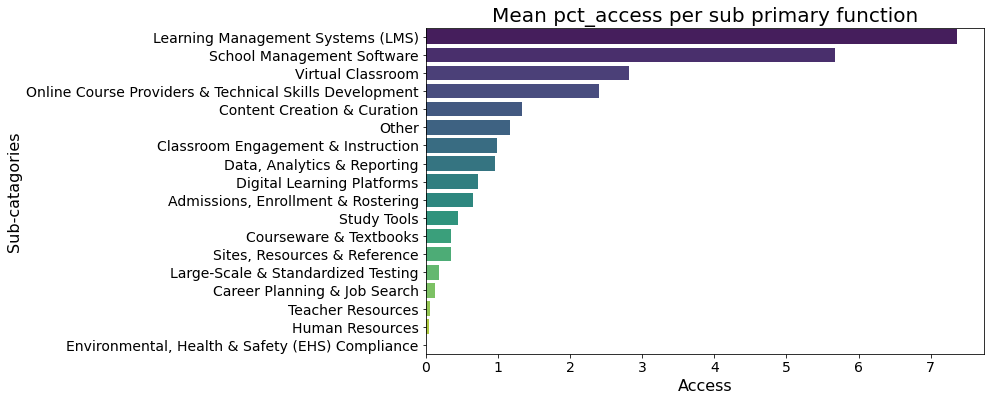

In [66]:
plot_bar1(Data,'pct_access','primary_function_sub','Mean pct_access per sub primary function','Access','Sub-catagories')

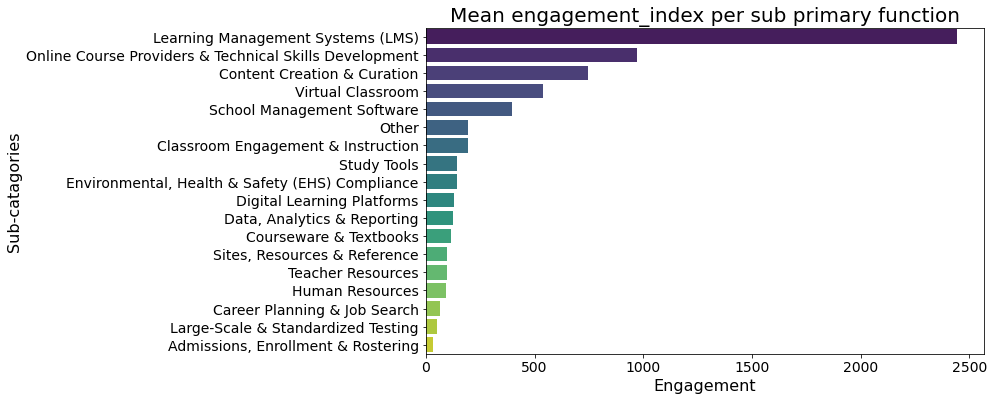

In [67]:
plot_bar1(Data,'engagement_index','primary_function_sub','Mean engagement_index per sub primary function','Engagement','Sub-catagories')

Let's analyse top 3 sub-catagories of primary function and remove weekends as well from the dataset as there are no classes on weekends to avoid confusions.

In [68]:
Data_sub=Data.loc[(Data["primary_function_sub"]=="Learning Management Systems (LMS)")]
pvd_acсess = Data_sub.groupby(['Product Name','time']).agg({'pct_access': 'mean'}).sort_values(['pct_access'],ascending=False).reset_index()
pvd_eng = Data_sub.groupby(['Product Name', 'time']).agg({'engagement_index': 'mean'}).sort_values(['engagement_index'],ascending=False).reset_index()

Data_sub=Data.loc[(Data["primary_function_sub"]=="Virtual Classroom")]
pvd1_acсess = Data_sub.groupby(['Product Name','time']).agg({'pct_access': 'mean'}).sort_values(['pct_access'],ascending=False).reset_index()
pvd1_eng = Data_sub.groupby(['Product Name', 'time']).agg({'engagement_index': 'mean'}).sort_values(['engagement_index'],ascending=False).reset_index()

Data_sub=Data.loc[(Data["primary_function_sub"]=="School Management Software")]
pvd2_acсess = Data_sub.groupby(['Product Name','time']).agg({'pct_access': 'mean'}).sort_values(['pct_access'],ascending=False).reset_index()
pvd2_eng = Data_sub.groupby(['Product Name', 'time']).agg({'engagement_index': 'mean'}).sort_values(['engagement_index'],ascending=False).reset_index()

for i in [pvd_acсess, pvd_eng, pvd1_acсess, pvd1_eng, pvd2_acсess, pvd2_eng]:
    i['time'] = pd.to_datetime(i['time'], errors='coerce')
    i['day_of_week'] = i['time'].dt.dayofweek
    i['month'] = i['time'].dt.month
    i = i[i.day_of_week < 5]


**Learning Management Systems(LMS) Sub-catagory:**

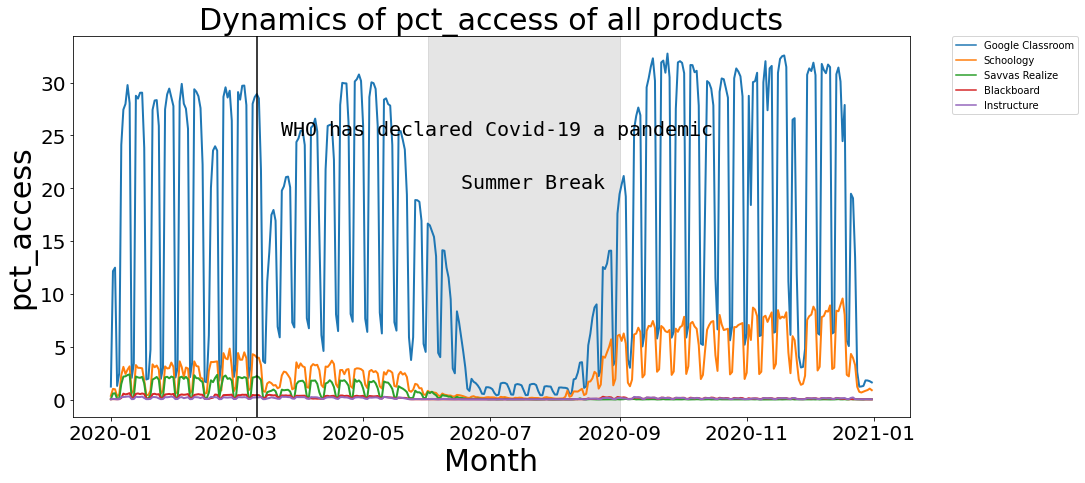

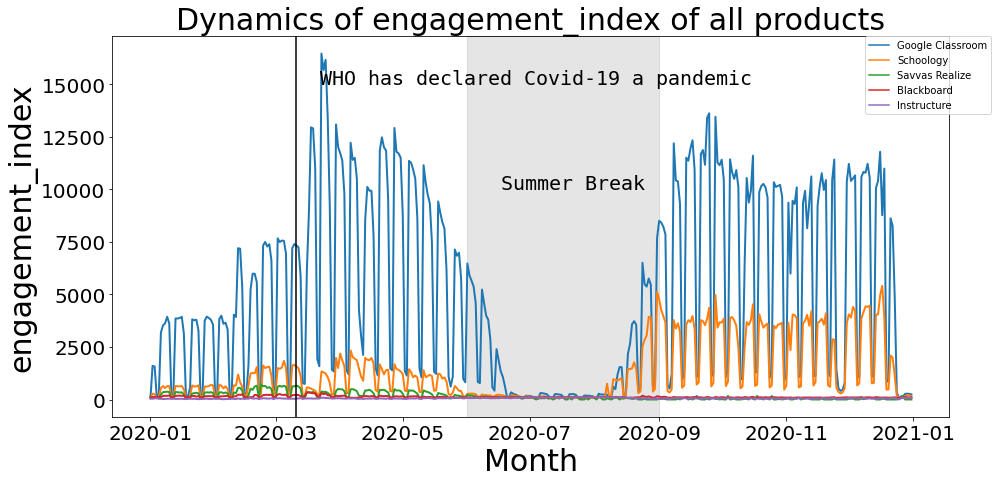

In [69]:
plot_line(pvd_acсess,"time","pct_access","Product Name","Dynamics of pct_access of all products","Month","pct_access",25,20)
plot_line(pvd_eng,"time","engagement_index","Product Name","Dynamics of engagement_index of all products","Month","engagement_index",15000,10000)

**Conclusion:**
> * Most of the schools use Google Classroom for digital learning during the pandemic. 

**School Management Software Sub-catagory:**

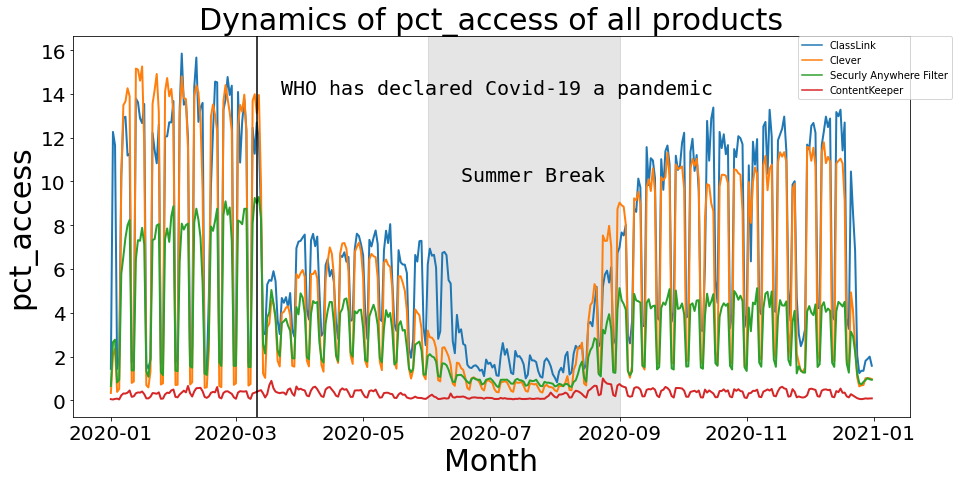

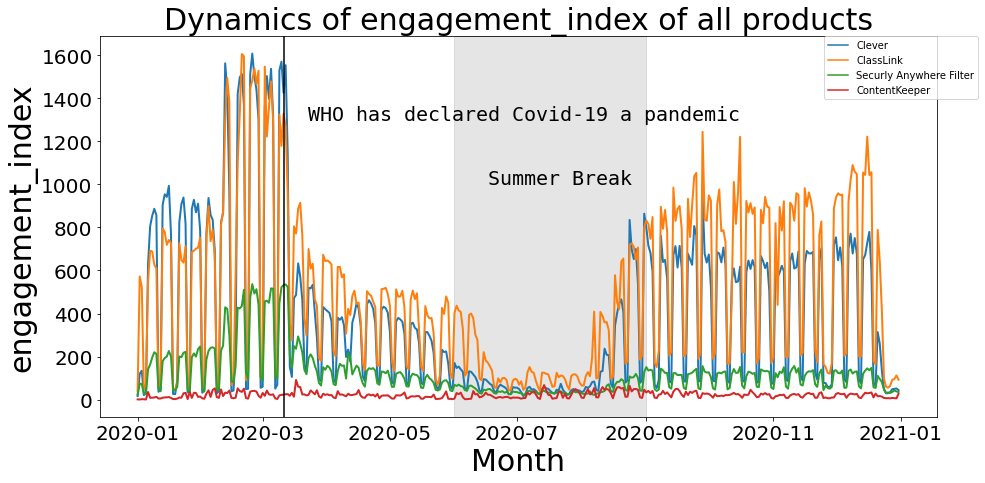

In [70]:
plot_line(pvd2_acсess,"time","pct_access","Product Name","Dynamics of pct_access of all products","Month","pct_access",14,10)
plot_line(pvd2_eng,"time","engagement_index","Product Name","Dynamics of engagement_index of all products","Month","engagement_index",1300,1000)

**Conclusion:**
> * Classlink and Clever are the two most used softwares for school management.

**Virtual Classroom Sub-catagoy:**

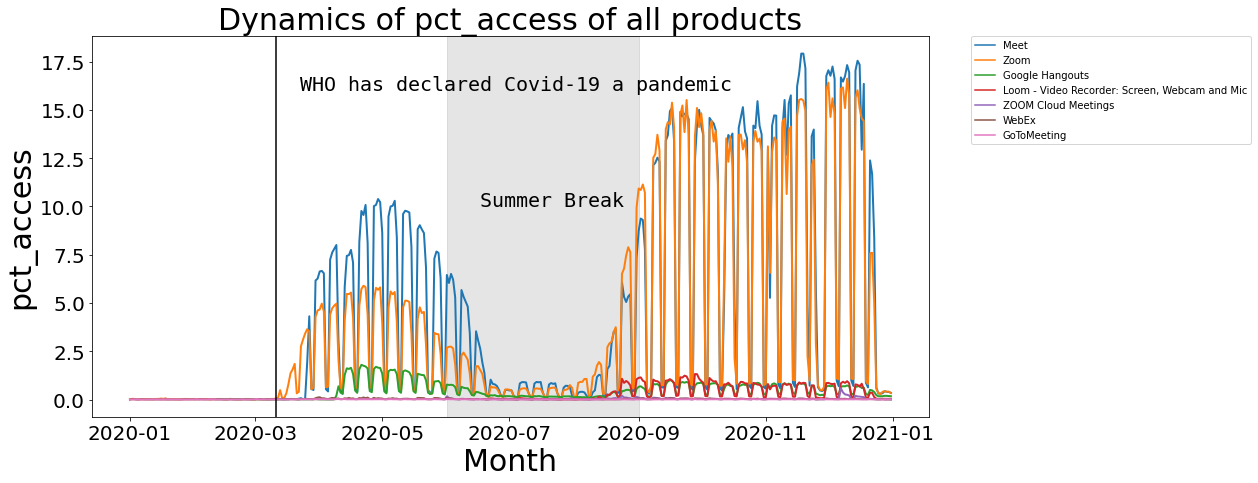

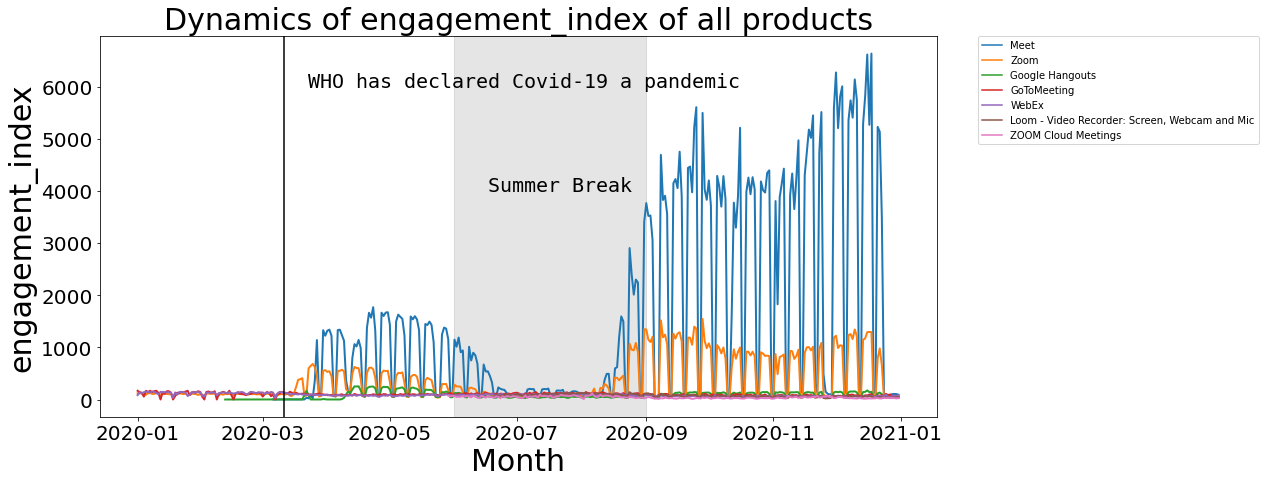

In [71]:
plot_line(pvd1_acсess,"time","pct_access","Product Name","Dynamics of pct_access of all products","Month","pct_access",16,10)
plot_line(pvd1_eng,"time","engagement_index","Product Name","Dynamics of engagement_index of all products","Month","engagement_index",6000,4000)

**Conclusion:**
> * Meet and Zoom are the two most prevalent software for online classes.
> * Work from Home or Virtual schooling started at the beginning after WHO declared the pandemic.
> * Summer break is during July and August, thus there are almost no activities.
> * The noticeable increase in use of Zoom and Meet products after summer break due to the new wave of pandemic.
> * There are a few drop points throughout the year. These might be the national holidays.



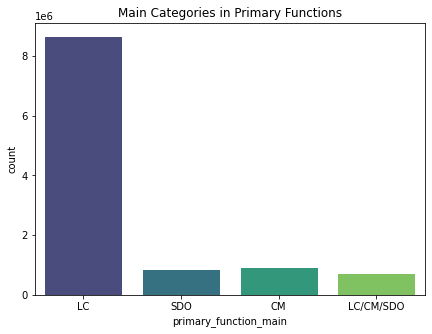

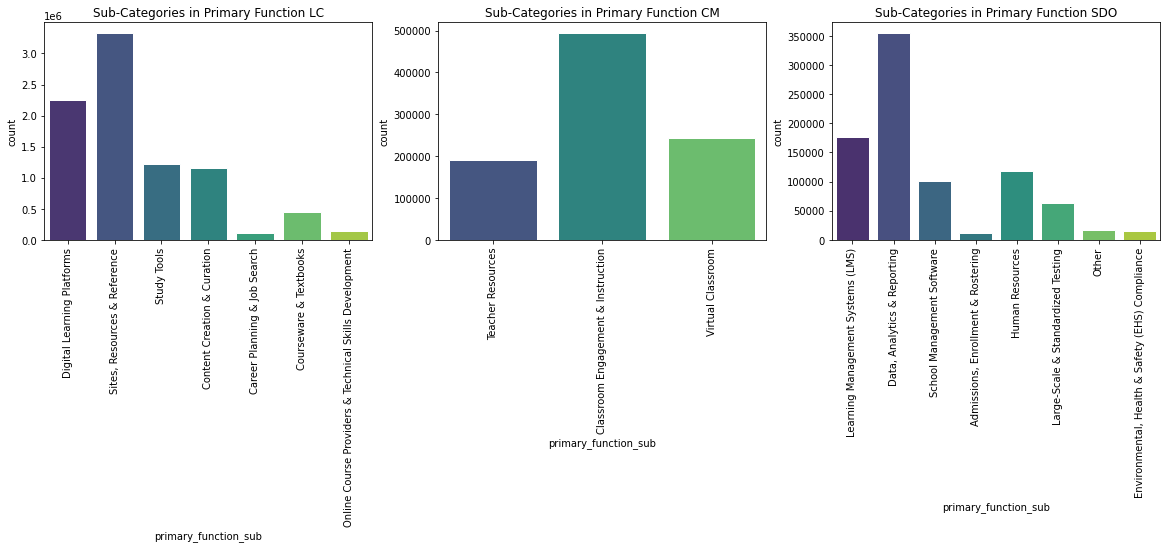

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
sns.countplot(data=Data, 
              x='primary_function_main', 
              edgecolor="white",
              palette="viridis")
plt.title('Main Categories in Primary Functions')

plt.show()


fig, ax = plt.subplots(1, 3, figsize=(20,4))
sns.countplot(data=Data[Data.primary_function_main == 'LC'], 
              x='primary_function_sub', 
              edgecolor="white",
              palette="viridis", ax=ax[0])
ax[0].set_title('Sub-Categories in Primary Function LC')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

sns.countplot(data=Data[Data.primary_function_main == 'CM'], 
              x='primary_function_sub', 
              edgecolor="white",
              palette="viridis", ax=ax[1])
ax[1].set_title('Sub-Categories in Primary Function CM')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

sns.countplot(data=Data[Data.primary_function_main == 'SDO'], 
              x='primary_function_sub', 
              edgecolor="white",
              palette="viridis", ax=ax[2])
ax[2].set_title('Sub-Categories in Primary Function SDO')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)
plt.show()

* Amongst the different learning tools, Learning & Curriculum (LC) had achieved the highest adoption. 

* **"Sites, Resources and Reference"** and **"Digital Learning Platform"** take the top spots in the list of primary essential sub-category.

# **Work in Progress**